# Multivariate Time Series Random-Forests

In multivariate time series classification problems, one is interested in classifying a C x T array of data, where C is the number of time series (denoted as channels) and T is the number of time points (based on the sampling rate). 

If we consider convolutional approaches that were very successful in image classification, we note that local convolutions contributed in two ways: i) shared weights decreased the number of parameters needed to be learned and ii) local information was able to be pooled successfully because images are inherently locally correlated. So in our context of a C x T image, then over small contiguous kernels, the image is correlated. For example, if the image is C x T = (28 x 28). We can take small patches: C' x T' = (2 x 2), and apply our learning algorithm, whether it is a random forest, or neural network. This is how Structured ReRF (or MORF) is implemented essentially in https://sporf.neurodata.io/demos/s-rerf/importancemap. Note that correlations are contiguous in space (i.e. rows and columns of the image array).

When we consider multivariate time series, there are indeed correlations over the channels (i.e. rows) and even over time (i.e. columns), but they are definitely not contiguous as in images! It does not matter how you stack the time series, unless they are spatiotemporal time series. For example, it doesn't matter if you have the following time series of a person's health:

    * blood temperature over time
    * eye movement over time
    * sugar intake over time
    
They could very well be shuffled in any way, and the information would still be the same, but there can be correlations in the time series that we take into account that are useful in classification.

## Multivariate Timeseries - Manifold Forests (MT-MORF)
Here, MT-MORF is in essence extending this idea from the image domain to the time series domain. Rather then taking contiguous kernel patches over the data array, we are taking kernel patches that are discontiguous along the "C" axis over the data array.

Visual Examples of Contiguous Kernels:
https://www.google.com/url?sa=i&url=https%3A%2F%2Fwww.saama.com%2Fdifferent-kinds-convolutional-filters%2F&psig=AOvVaw1KSgQ0V39eN9S_JB6JAoGc&ust=1584819248892000&source=images&cd=vfe&ved=0CAIQjRxqFwoTCMCO4_rlqegCFQAAAAAdAAAAABAD

Visual Examples of Discontiguous Kernels:
https://www.google.com/url?sa=i&url=https%3A%2F%2Fwww.mdpi.com%2F2076-3417%2F10%2F5%2F1727%2Fhtm&psig=AOvVaw39o_oj3W8Lkbn-Pq6nbboy&ust=1584819310634000&source=images&cd=vfe&ved=0CAIQjRxqFwoTCNDuj5TmqegCFQAAAAAdAAAAABAD

In [6]:
cd ../../../

/home/adam2392/Documents/RerF


In [7]:
import pandas as pd
from scipy import stats
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
%matplotlib inline
import seaborn as sns

import pickle
import time
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier

from rerf.rerfClassifier import rerfClassifier

import warnings
warnings.simplefilter('ignore')

In [9]:
def correlated_samples(nchs, n, cls=0, num_noise_chs=3, i=1):
    # The desired mean values of the sample.
    mu = np.array([5.0, 
                    0.0, 
                    10.0])
    
    y_noise = np.random.random((num_noise_chs, n))

    # The desired covariance matrix.
    if cls == 0:
        r = np.array([
            [  3, -2.75*i, -2.00*i],
            [ -2.75*i,  5,  1.50*i],
            [ -2.00*i,  1.50*i,  1]
        ])
    elif cls == 1:
        r = np.array([
            [  3, 0, 0],
            [ 0,  5, 0],
            [ 0,  0,  1]
        ])
    
    # Generate the random samples.
    y = np.random.multivariate_normal(mu, r, size=n).T
    
    y = np.vstack((y[0,:], y_noise[0,:], y[1,:], 
                        y_noise[1,:], y[2,:], y_noise[2,:]))
    
    return y

In [10]:
def simulate_data(cov_factor):
    np.random.seed(1234)

    # length of data sequence
    ns = np.array([50,100,200,
                   400,1000,2000
                  ])
    test_size = 0.5

    # simulated data parameters
    T = 100
    nchs = 6

    # initialize data structures for train/test data
    X_train, Y_train = np.empty(shape=(0,nchs,T)), np.empty(shape=(0))
    X_test, Y_test = np.empty(shape=(0,nchs,T)), np.empty(shape=(0))

    # simulate over varying sizes of data sequence
    for n in ns:
        y = []
        X = []

        # generate correlated multi-variate time series
        for i in range(n):
            _x = correlated_samples(nchs, T, cls=0, i=cov_factor)
            X.append(_x)
            y.append(0)
        for i in range(n):
            _x = correlated_samples(nchs, T, cls=1, i=cov_factor)
            X.append(_x)
            y.append(1)
        X = np.array(X)
        y = np.array(y)

        # perform training test split
        _X_train, _X_test, _y_train, _y_test = train_test_split(X, y, 
                                                            test_size=test_size, 
                                                            random_state=42)
        X_train = np.vstack((X_train, _X_train))
        Y_train = np.hstack((Y_train, _y_train))
        X_test = np.vstack((X_test, _X_test))
        Y_test = np.hstack((Y_test, _y_test))

    X_train = X_train.reshape(X_train.shape[0], -1)
    X_test = X_test.reshape(X_test.shape[0], -1)
    return X_train, Y_train, X_test, Y_test

In [11]:
np.random.seed(1234)

# length of data sequence
ns = np.array([50,100,200,
               400,1000,2000
              ])
test_size = 0.5

# simulated data parameters
T = 100
nchs = 6

# initialize data structures for train/test data
X_train, Y_train = np.empty(shape=(0,nchs,T)), np.empty(shape=(0))
X_test, Y_test = np.empty(shape=(0,nchs,T)), np.empty(shape=(0))

# simulate over varying sizes of data sequence
for n in ns:
    y = []
    X = []
    
    # generate correlated multi-variate time series
    for i in range(n):
        _x = correlated_samples(nchs, T, cls=0)
        X.append(_x)
        y.append(0)
    for i in range(n):
        _x = correlated_samples(nchs, T, cls=1)
        X.append(_x)
        y.append(1)
    X = np.array(X)
    y = np.array(y)
    
    # perform training test split
    _X_train, _X_test, _y_train, _y_test = train_test_split(X, y, 
                                                        test_size=test_size, 
                                                        random_state=42)
    X_train = np.vstack((X_train, _X_train))
    Y_train = np.hstack((Y_train, _y_train))
    X_test = np.vstack((X_test, _X_test))
    Y_test = np.hstack((Y_test, _y_test))

print(X_train.shape)
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)
print(X_train.shape, Y_train.shape, X_test.shape)

(3750, 6, 100)
(3750, 600) (3750,) (3750, 600)


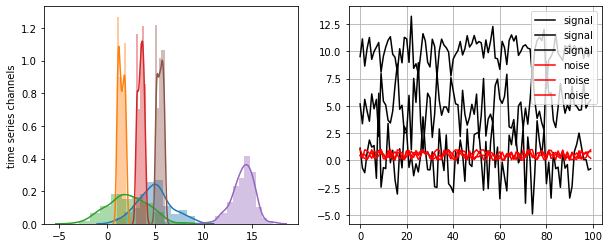

In [12]:
# Plot various projections of the samples.
fig, axs = plt.subplots(1,2,figsize=(10,4))
ax = axs[0]
for i in range(6):
    sns.distplot(X_train[0, i*T:T*(i+1)]+np.r_[i], ax=ax)
ax.set_ylabel('time series channels')
# plt.axis('equal')
plt.grid(True)

ax = axs[1]
for i in [0, 2, 4]:
    ax.plot(X_train[0, i*T:T*(i+1)], 'k', label='signal')
for i in [1, 3, 5]:
    ax.plot(X_train[0, i*T:T*(i+1)], 'r', label='noise')
ax.legend()
plt.show()

# Initialize Classifier and Baseline Models

In [13]:
## Setup for run
names = {"Log. Reg": "blue", "Lin. SVM":"firebrick", "SVM":"purple",
          "kNN": "black", "RF":"#f86000", "MLP":"green", "S-RerF":"red", "MT-MORF": "orange"}

ncores=1
num_runs=1
n_est=100  # number of estimators

classifiers = [
    LogisticRegression(random_state=0, n_jobs=ncores, solver='liblinear'),
    LinearSVC(),
    SVC(C=1.0, kernel='rbf', gamma='auto',random_state=0),
    KNeighborsClassifier(3, n_jobs=ncores),
    RandomForestClassifier(n_estimators=n_est, max_features='auto', n_jobs=ncores),
    MLPClassifier(hidden_layer_sizes=(100, ), random_state=0, max_iter=1000),
    rerfClassifier(projection_matrix="S-RerF",
                   max_features='auto',
                   n_jobs=ncores,
                    n_estimators=n_est,
                    oob_score=False,
                    random_state=0,
                    image_height=nchs,
                    image_width=T,
                    patch_height_max=2,
                    patch_height_min=1,
                    patch_width_max=20,
                    patch_width_min=2
                   ),
    rerfClassifier(projection_matrix="MT-MORF",
                   max_features='auto',
                   n_jobs=ncores,
                    n_estimators=n_est,
                    oob_score=False,
                    random_state=0,
                    image_height=nchs,
                    image_width=T,
                    patch_height_max=2,
                    patch_height_min=1,
                    patch_width_max=20,
                    patch_width_min=2
                   )
    ]

# Run Classification Comparison Experiment

Perform a classification over all models, and then summarize in a figure

In [14]:
runList = [(n, clf, run) for n in ns\
                       for clf in zip(classifiers, [key for key in names])\
                       for run in range(num_runs)]
print("About to run", len(runList), "clf experiments")
print(n)
print(ns)
print(len(classifiers))
print(num_runs)

About to run 48 clf experiments
2000
[  50  100  200  400 1000 2000]
8
1


In [9]:
# Train each classifier on each dataset size, then test
# Prep output file:
f = open('./mt-morf_impulse_experiment.csv', 'w+')
f.write("classifier,n,Lhat,trainTime,testTime,iterate\n")
f.flush()

for n, clf, iteration in tqdm(runList):
    # print(clf)
    if X_train.ndim == 3:
        X_train = X_train.reshape(-1, X_train.shape[-1]).T
    if X_test.ndim == 3:
        X_test = X_test.reshape(-1, X_test.shape[-1]).T
    X = X_train[:n]
    y = Y_train[:n]

    trainStartTime = time.time()
    clf[0].fit(X, y)
    trainEndTime = time.time()
    trainTime = trainEndTime - trainStartTime

    testStartTime = time.time()
    out = clf[0].predict(X_test)
    testEndTime = time.time()
    testTime = testEndTime - testStartTime

    lhat = np.mean(np.not_equal(out, Y_test).astype(int))


    ####("variable,Lhat,trainTime,testTime,iterate")
    f.write(f"{clf[1]}, {n}, {lhat:2.9f}, {trainTime:2.9f}, {testTime:2.9f}, {iteration}\n")
    f.flush()

f.close()

100%|██████████| 48/48 [01:25<00:00,  1.77s/it]


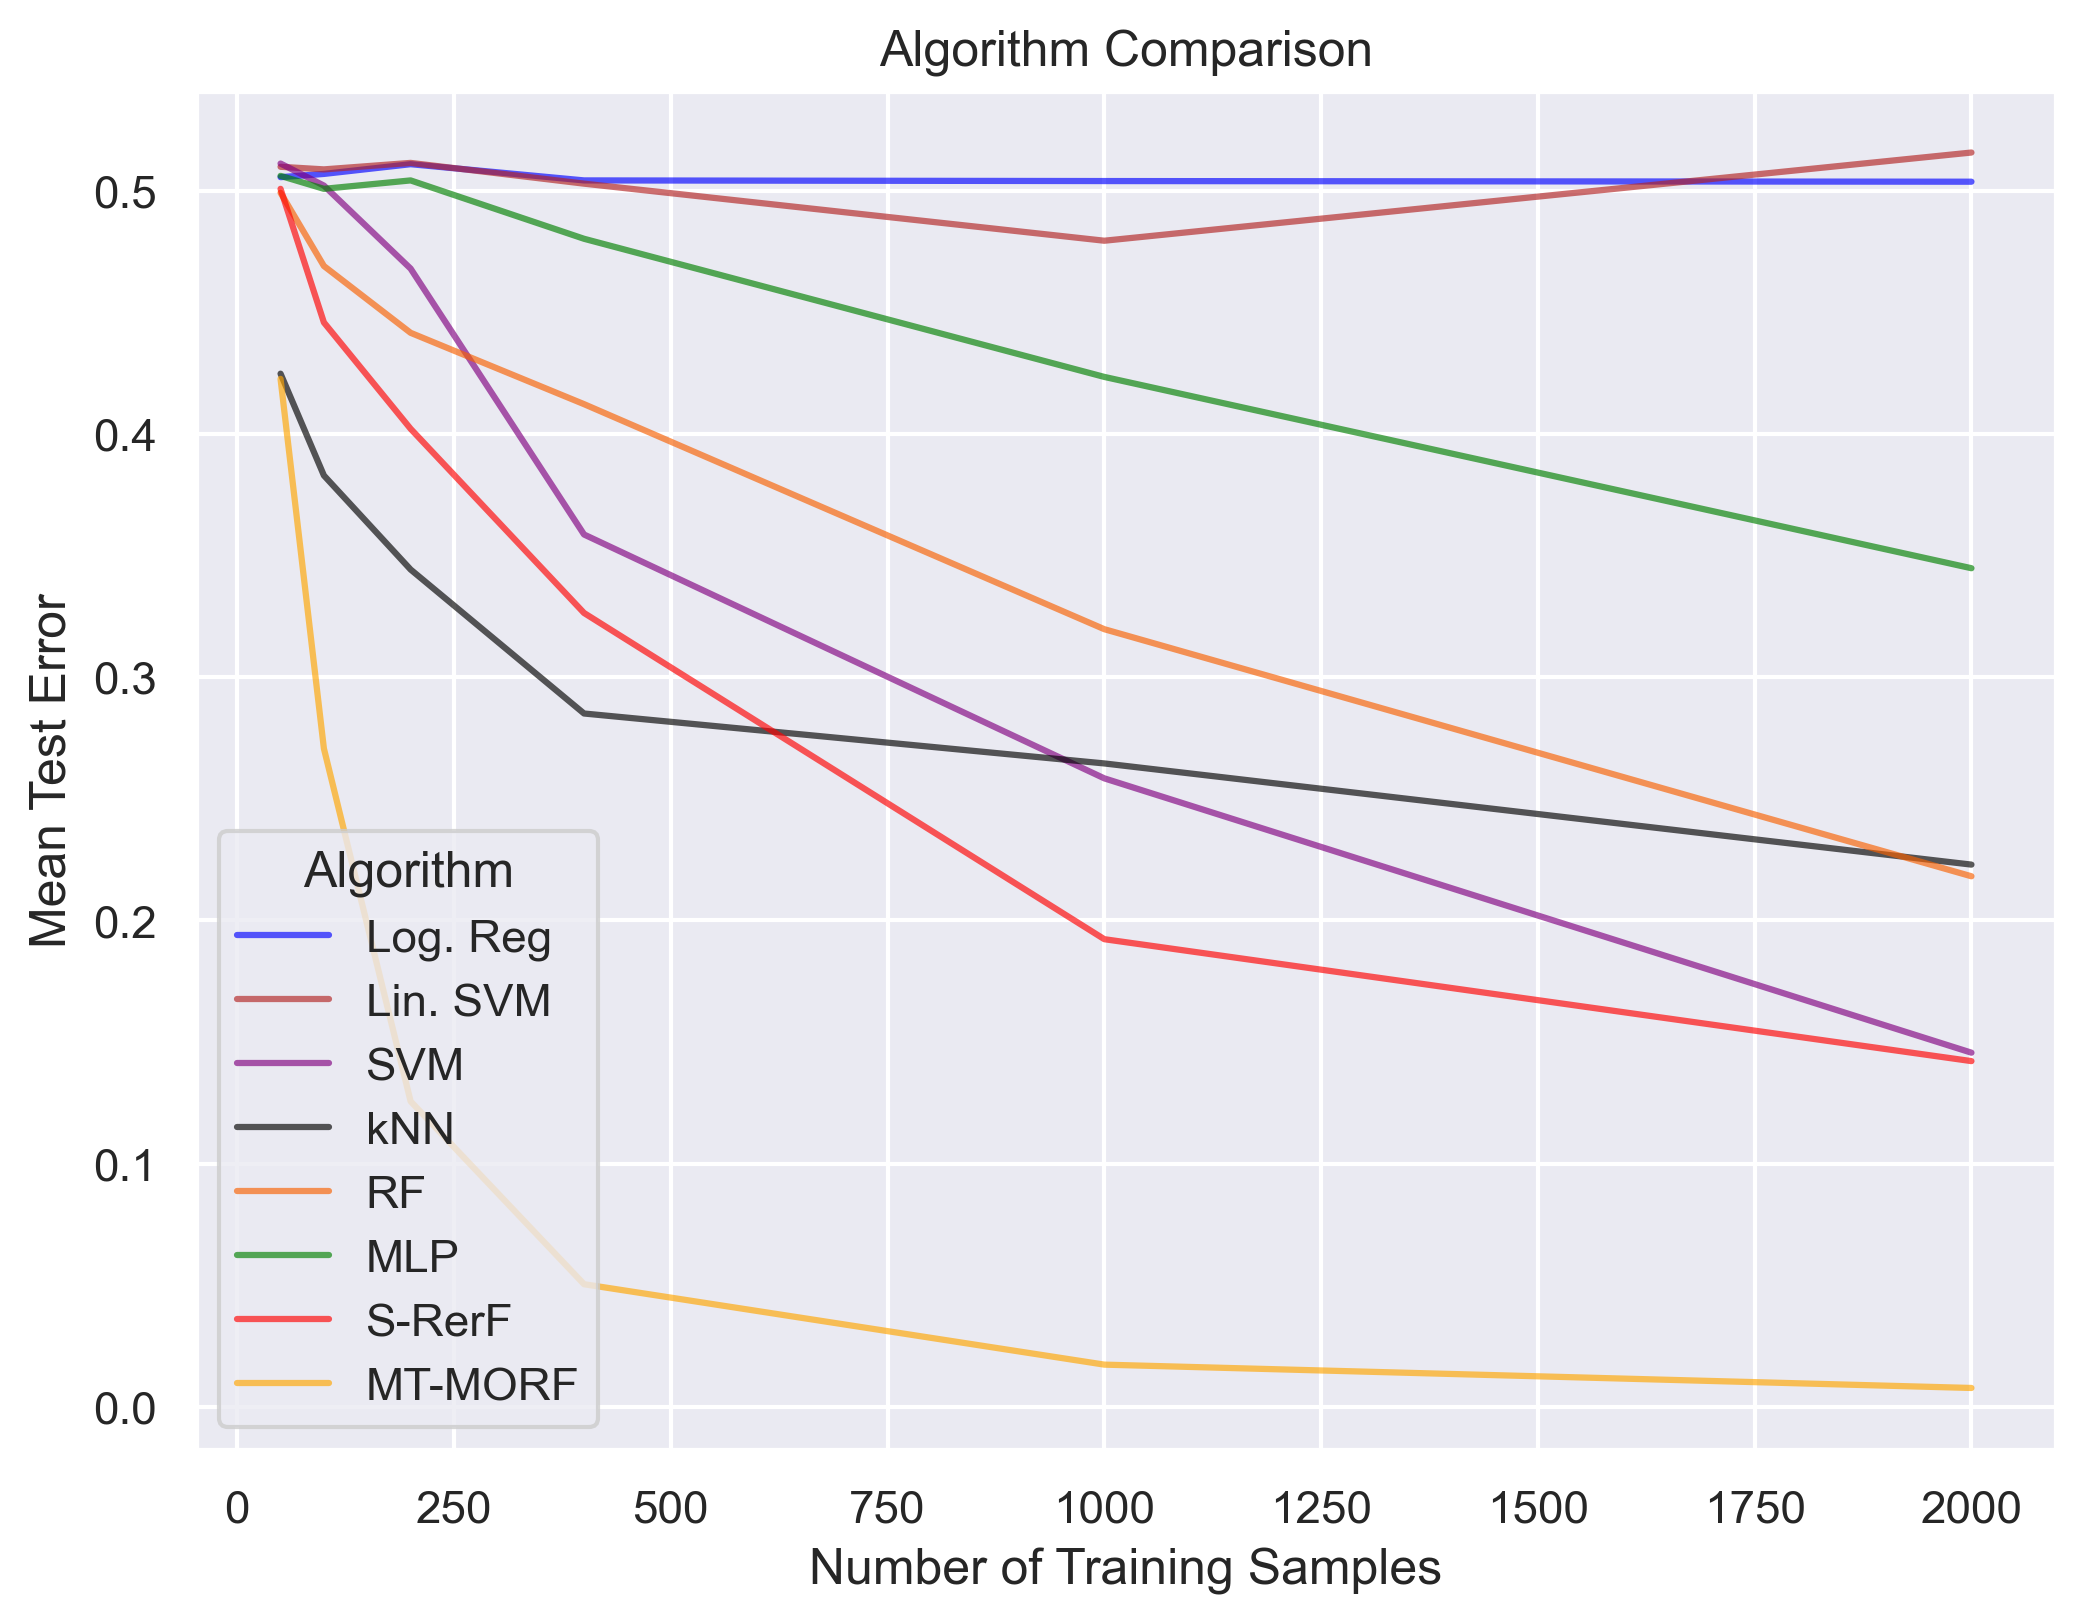

In [16]:
dat = pd.read_csv("mt-morf_impulse_experiment.csv")

d1 = pd.DataFrame(columns = ['classifier', 'n', 'Lhat', 'color'])

k = 0
for ni in np.unique(dat['n']):
    for cl in np.unique(dat['classifier']):

        tmp = dat[np.logical_and(dat['classifier'] == cl,dat['n'] == ni)][['n', 'Lhat']]

        list(tmp.mean())
        d1.loc[k] = [cl] + list(tmp.mean()) + [names[cl]]
        k += 1


sns.set(style="darkgrid", rc={'figure.figsize':[12,8], 'figure.dpi': 300})
fig, ax = plt.subplots(figsize = (8,6))

for key in names.keys():
    grp = d1[d1['classifier'] == key]
    ax = grp.plot(ax=ax, kind='line', x='n', y='Lhat', label=key, \
            c = names[key], alpha =0.65)
    #ax.set_yscale('log')

plt.legend(loc='best',title='Algorithm')
plt.title('Algorithm Comparison')
plt.ylabel('Mean Test Error')
plt.xlabel('Number of Training Samples')
#plt.savefig('./s-rerf_impulse_experiment.pdf',dpi=300,format='pdf')
plt.show()

# Compare Effect of Covariance Magnitude

100%|██████████| 48/48 [01:23<00:00,  1.75s/it]


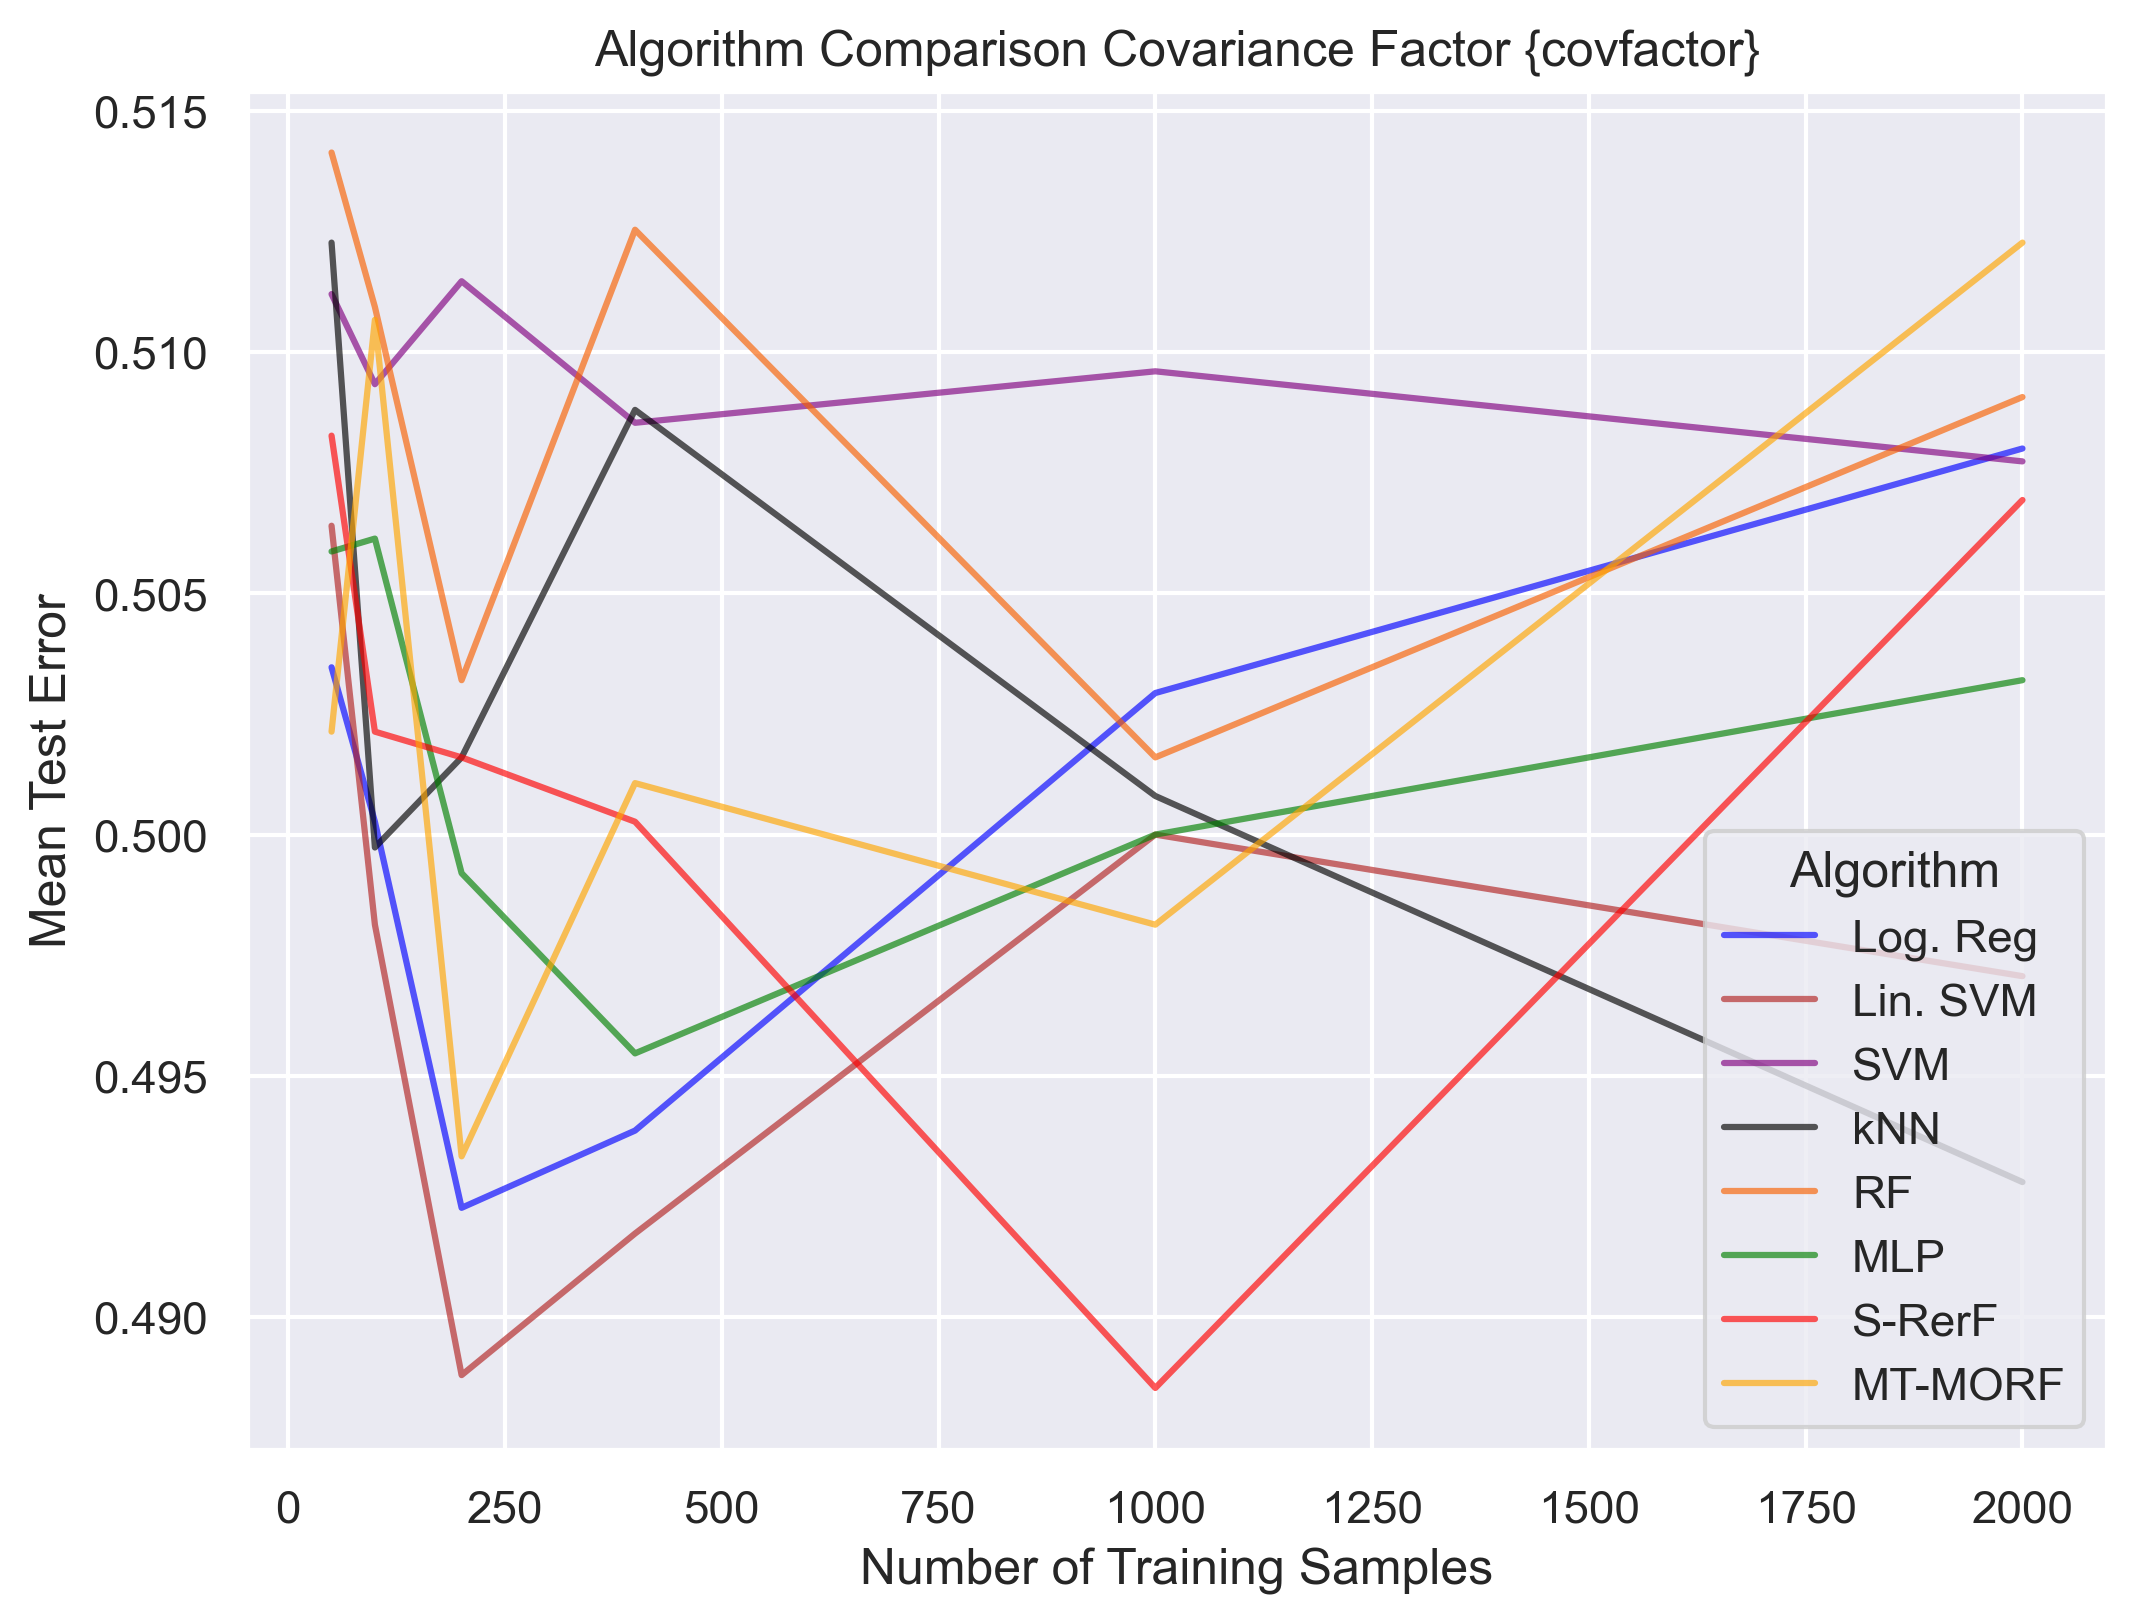

100%|██████████| 48/48 [01:24<00:00,  1.75s/it]


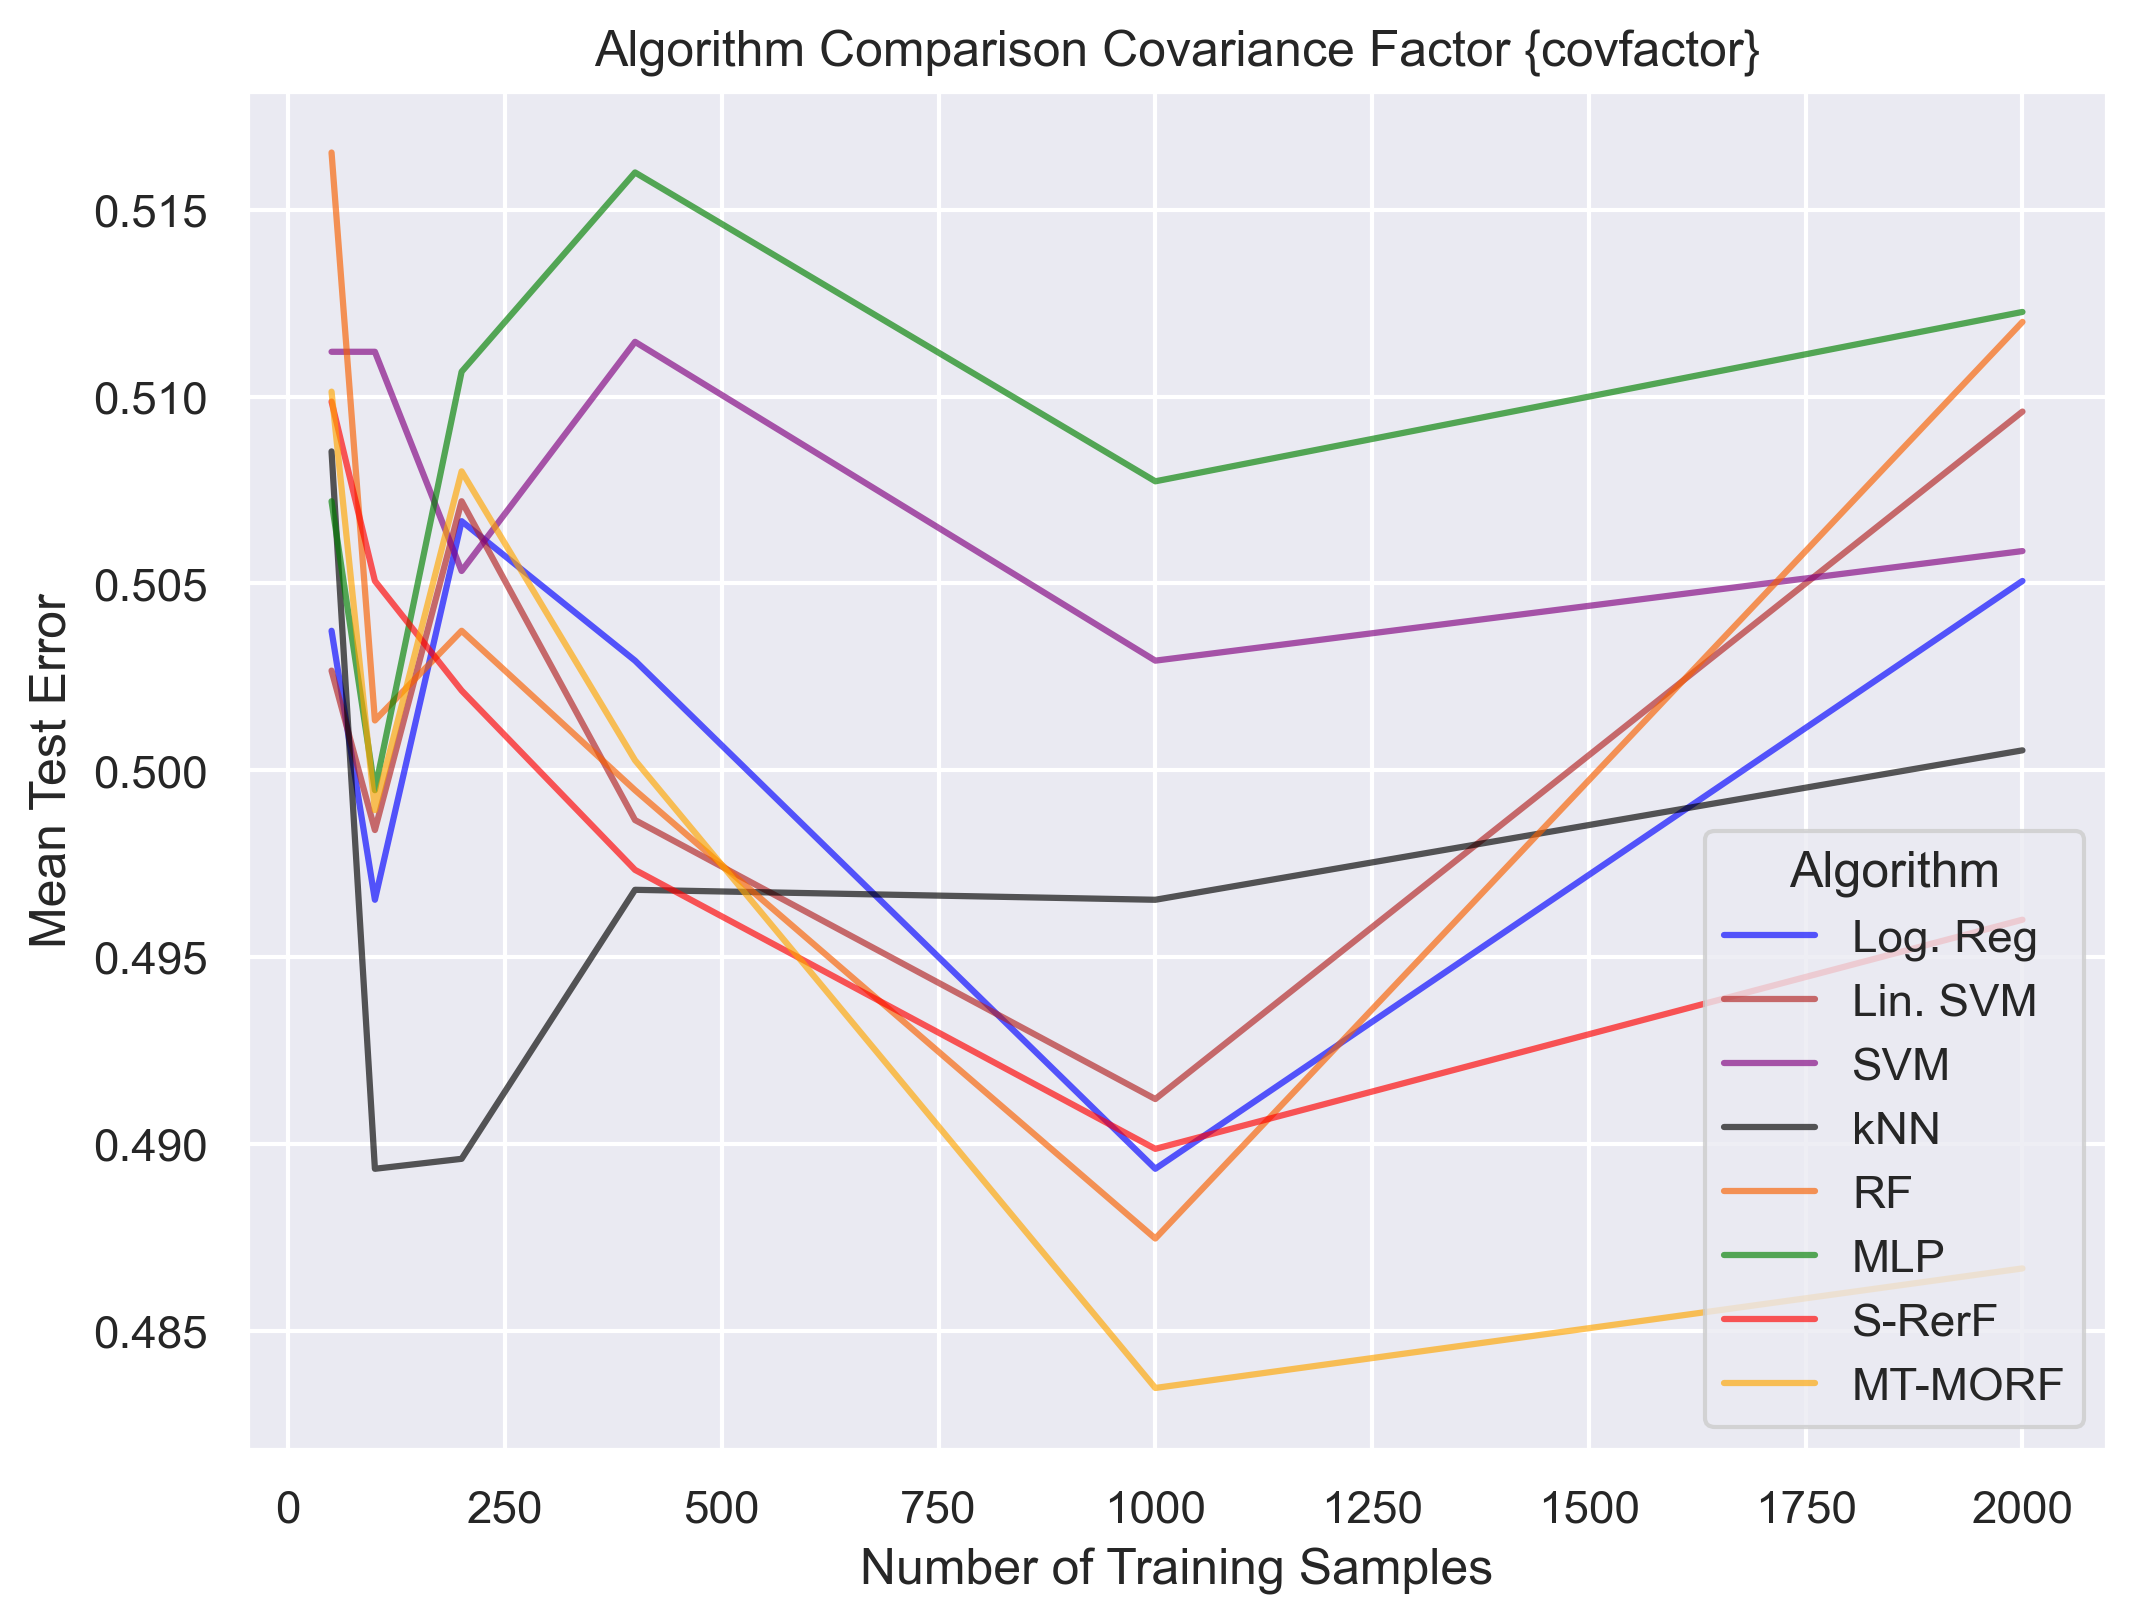

100%|██████████| 48/48 [01:25<00:00,  1.77s/it]


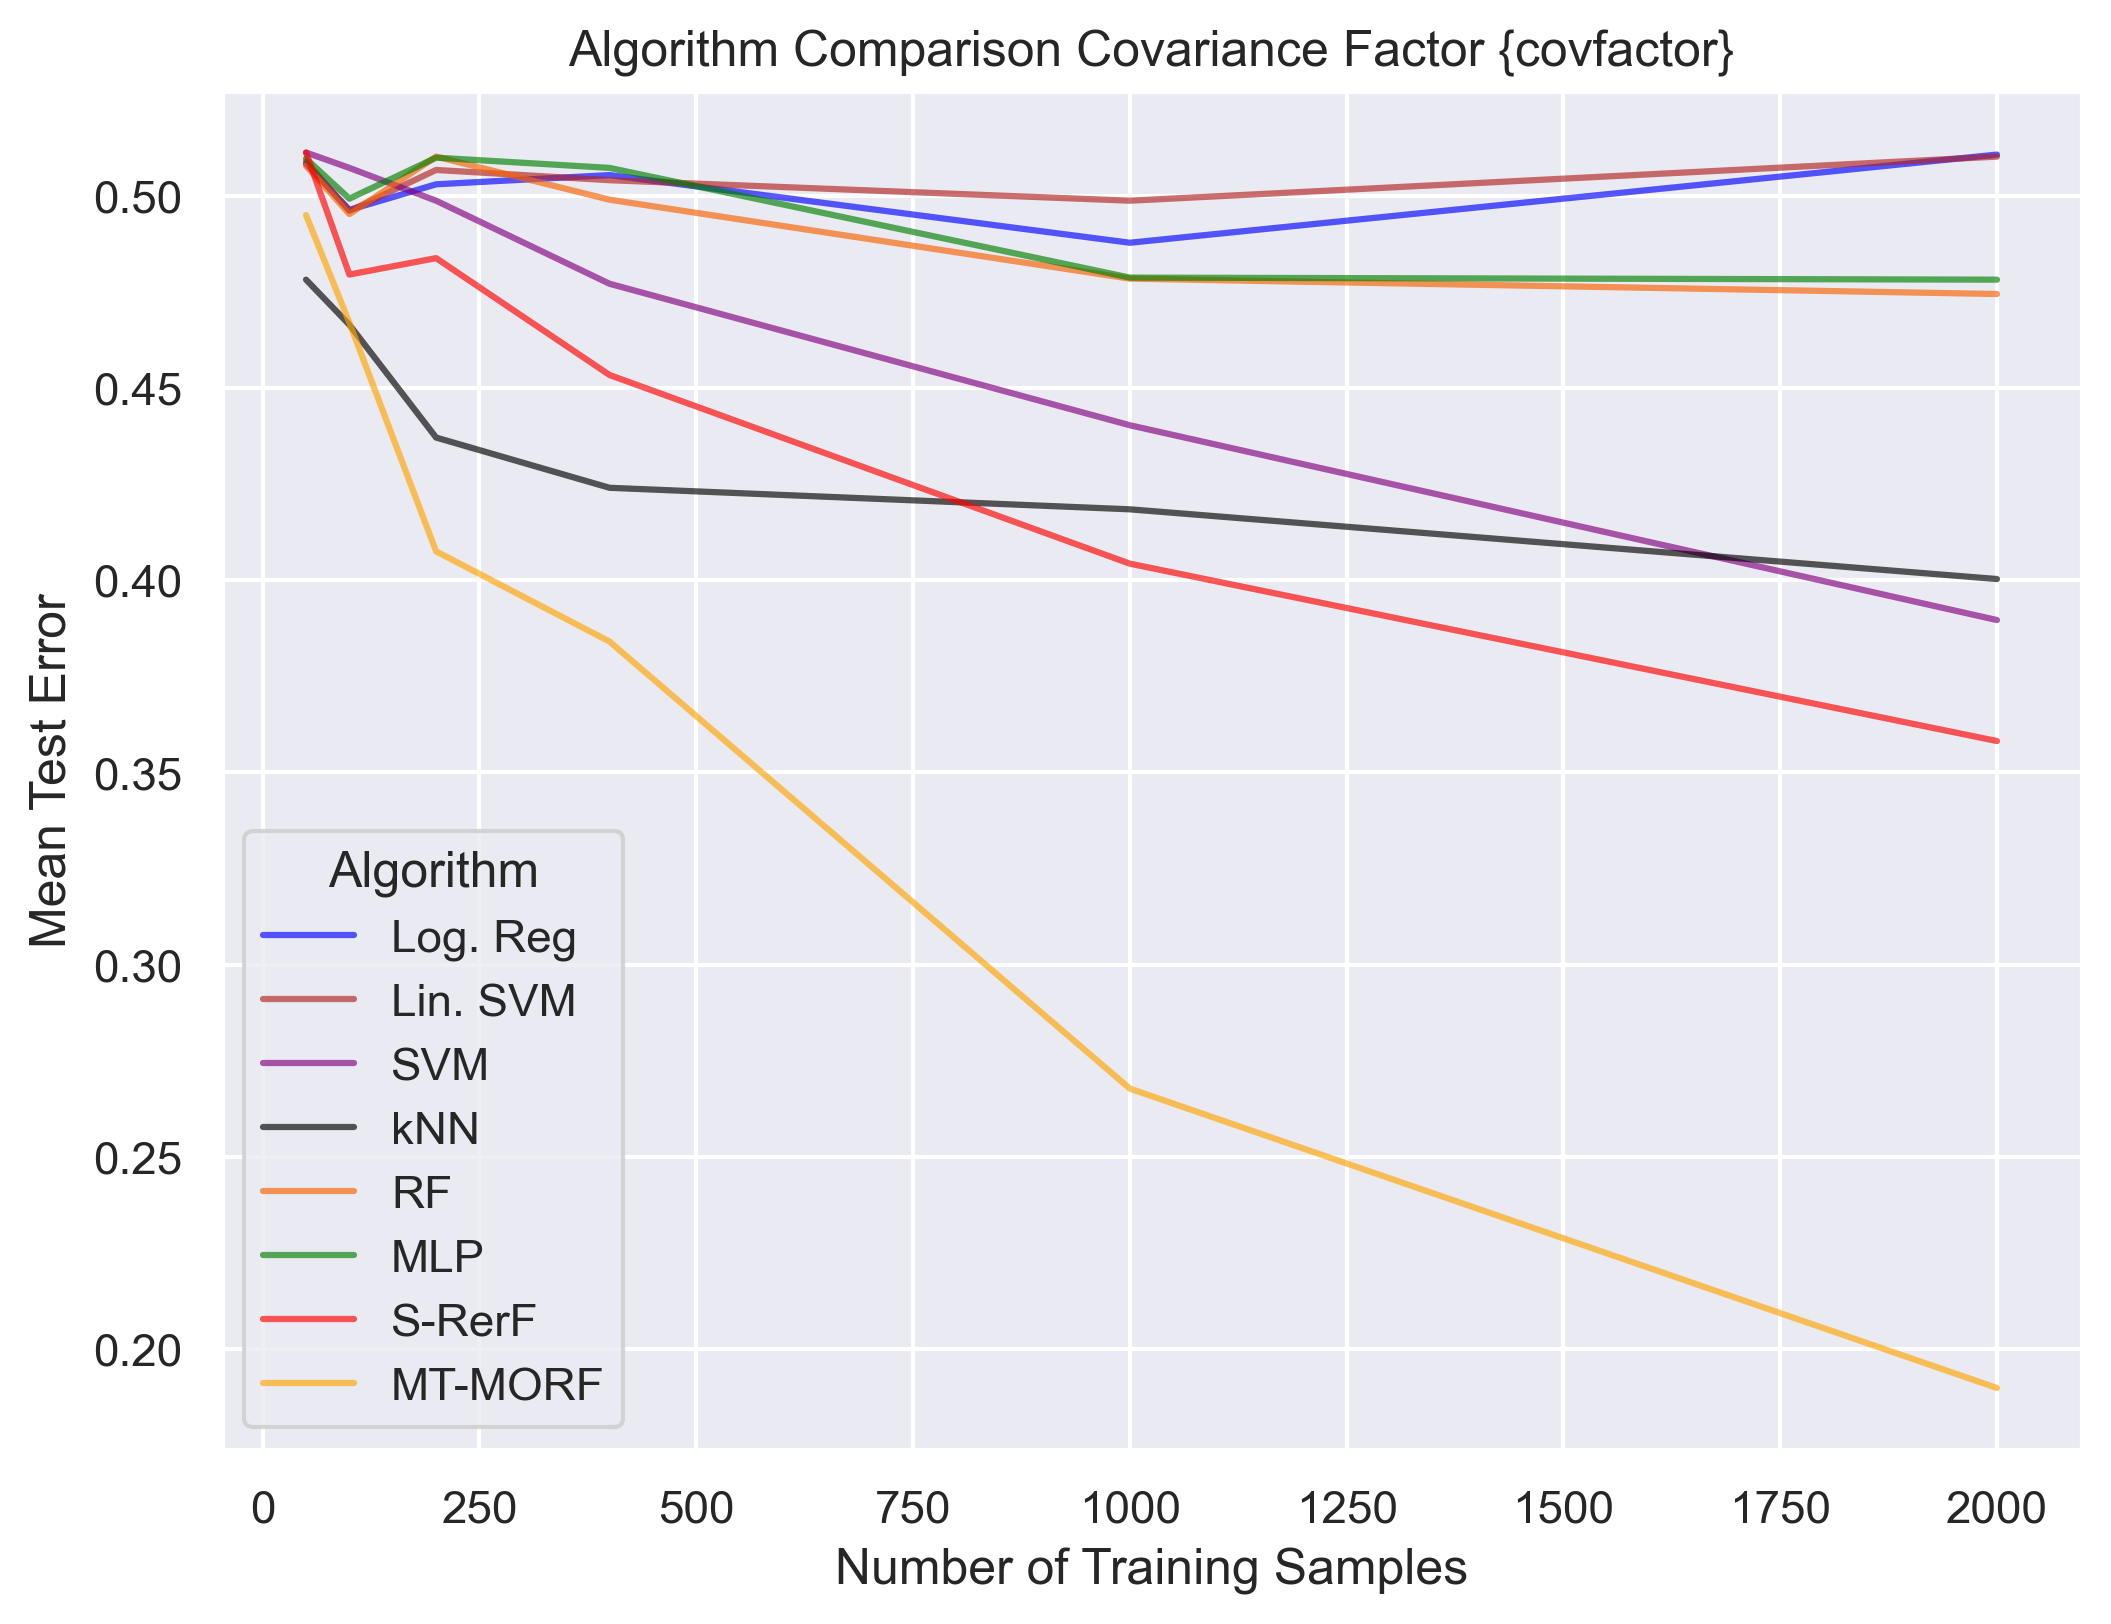

100%|██████████| 48/48 [01:22<00:00,  1.72s/it]


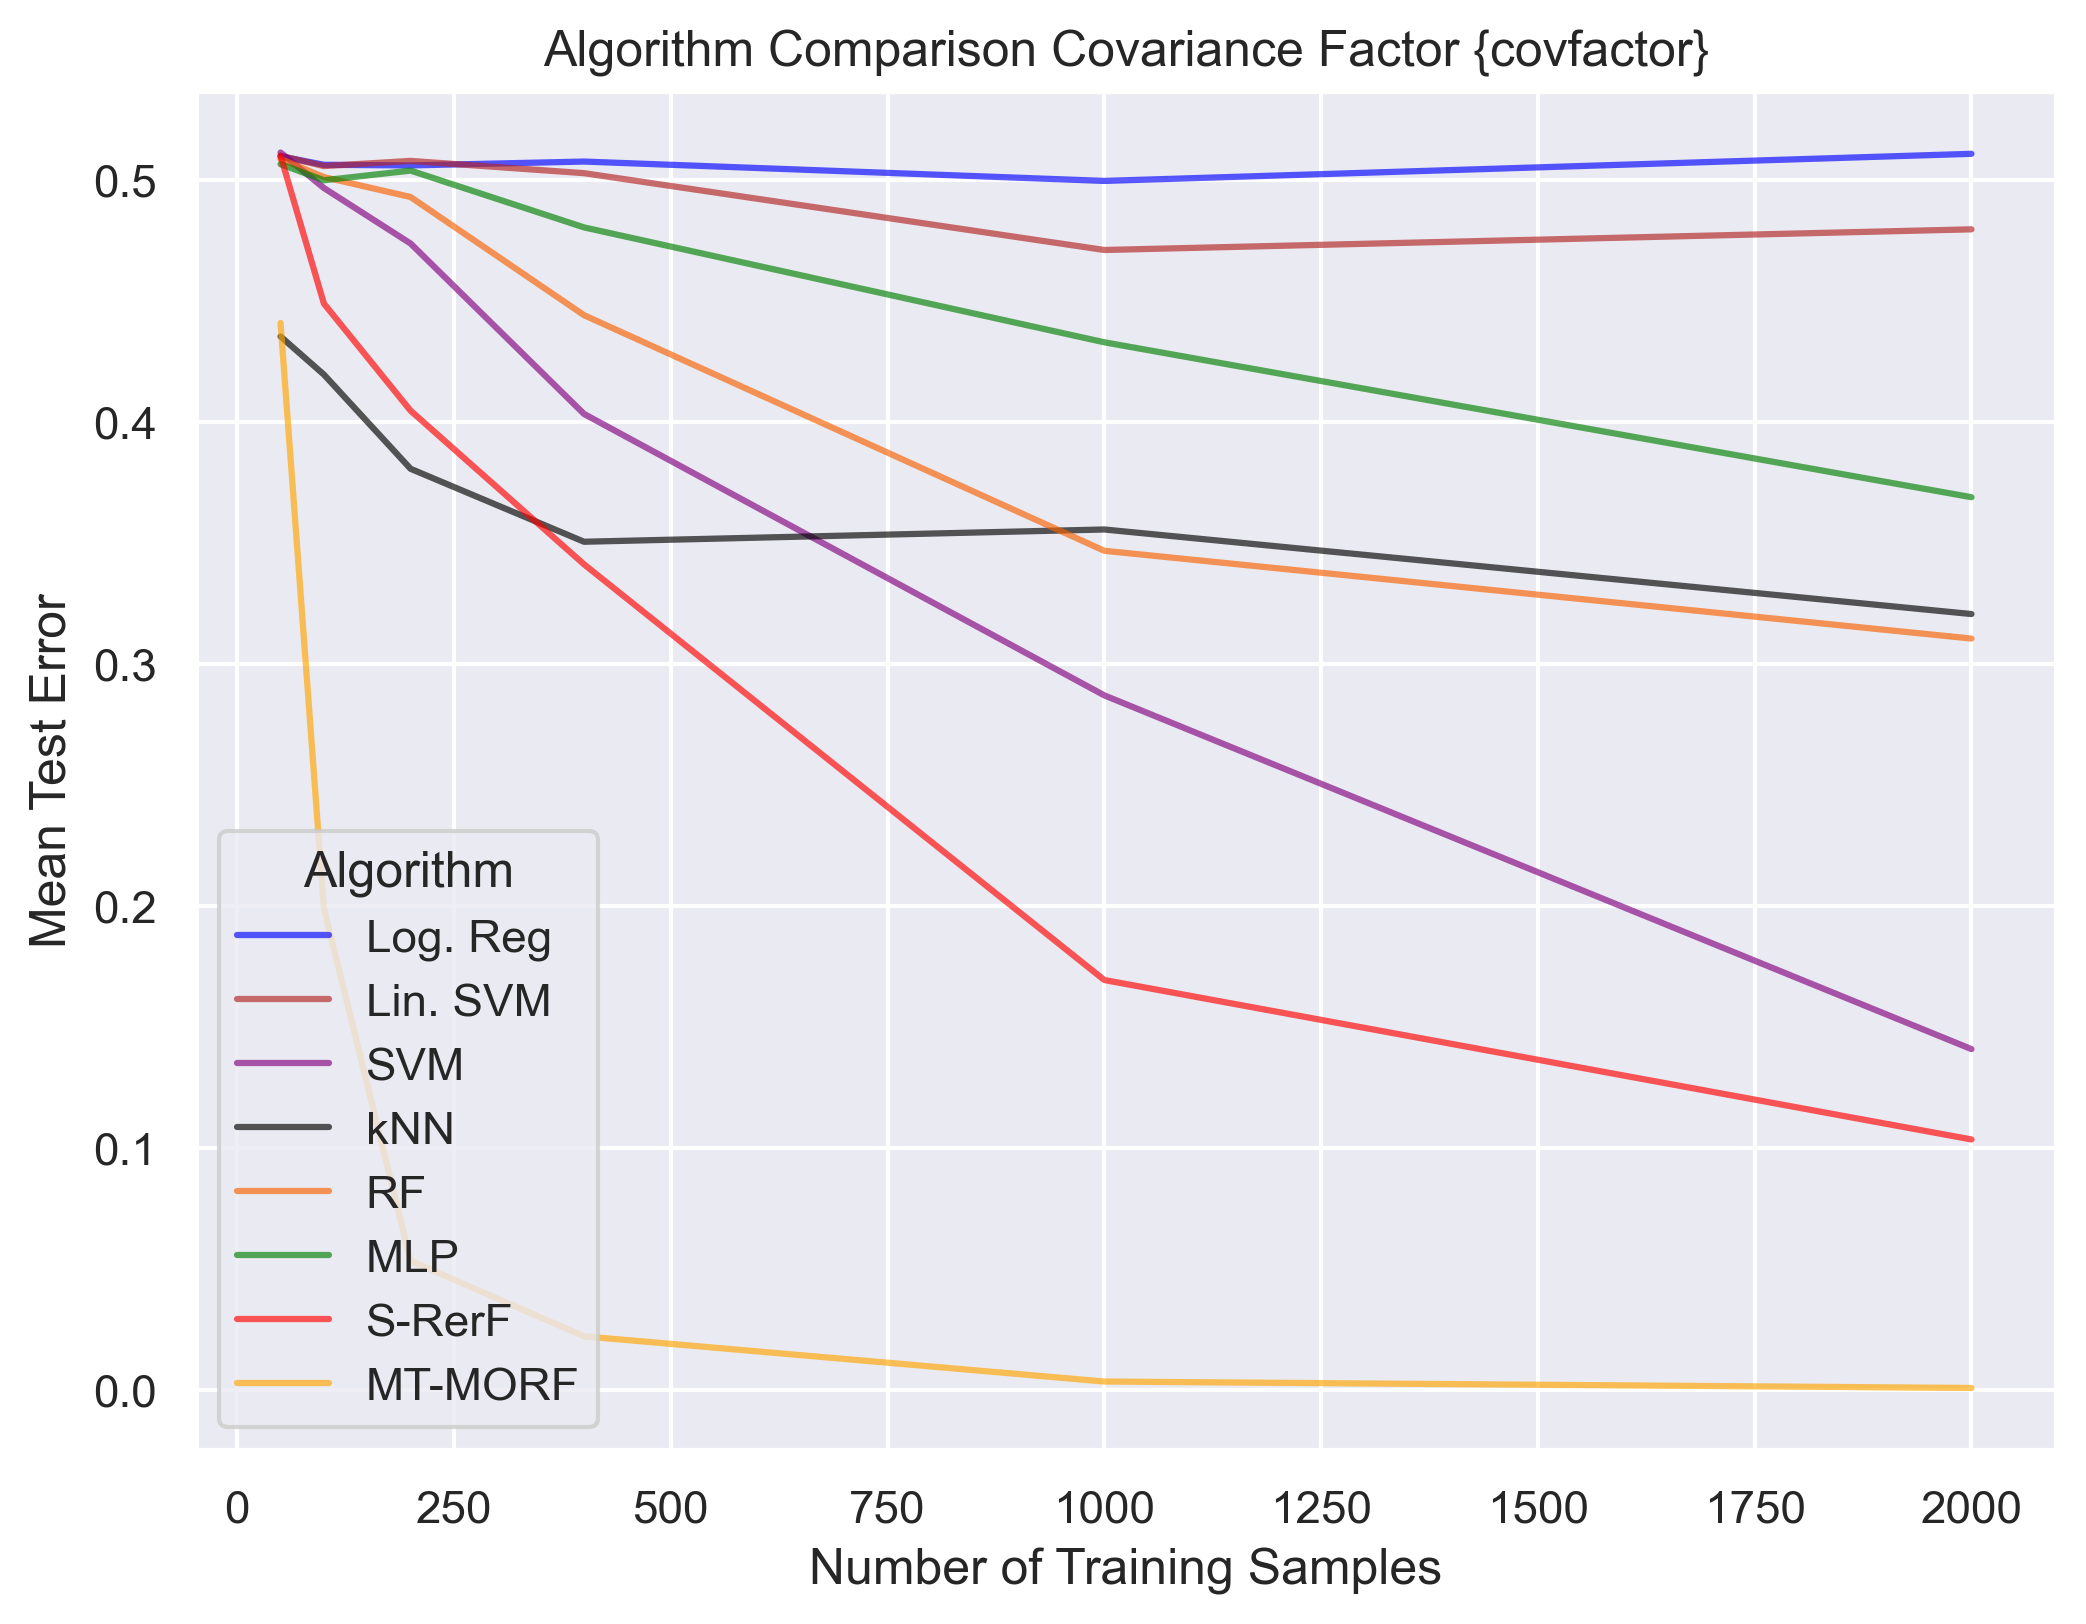

In [15]:
for cov_factor in [1e-5, 0.1, 0.5, 0.9]:
    X_train, y_train, X_test, y_test = simulate_data(cov_factor)
    
    # Train each classifier on each dataset size, then test
    # Prep output file:
    fname = f'./mt-morf_impulse_experiment_covfactor{cov_factor}.csv'
    f = open(fname, 'w+')
    f.write("classifier,n,Lhat,trainTime,testTime,iterate\n")
    f.flush()

    for n, clf, iteration in tqdm(runList):
        # print(clf)
        if X_train.ndim == 3:
            X_train = X_train.reshape(-1, X_train.shape[-1]).T
        if X_test.ndim == 3:
            X_test = X_test.reshape(-1, X_test.shape[-1]).T
        X = X_train[:n]
        y = Y_train[:n]

        trainStartTime = time.time()
        clf[0].fit(X, y)
        trainEndTime = time.time()
        trainTime = trainEndTime - trainStartTime

        testStartTime = time.time()
        out = clf[0].predict(X_test)
        testEndTime = time.time()
        testTime = testEndTime - testStartTime

        lhat = np.mean(np.not_equal(out, Y_test).astype(int))


        ####("variable,Lhat,trainTime,testTime,iterate")
        f.write(f"{clf[1]}, {n}, {lhat:2.9f}, {trainTime:2.9f}, {testTime:2.9f}, {iteration}\n")
        f.flush()

    f.close()
    
    dat = pd.read_csv(fname)

    d1 = pd.DataFrame(columns = ['classifier', 'n', 'Lhat', 'color'])

    k = 0
    for ni in np.unique(dat['n']):
        for cl in np.unique(dat['classifier']):

            tmp = dat[np.logical_and(dat['classifier'] == cl,dat['n'] == ni)][['n', 'Lhat']]

            list(tmp.mean())
            d1.loc[k] = [cl] + list(tmp.mean()) + [names[cl]]
            k += 1


    sns.set(style="darkgrid", rc={'figure.figsize':[12,8], 'figure.dpi': 300})
    fig, ax = plt.subplots(figsize = (8,6))

    for key in names.keys():
        grp = d1[d1['classifier'] == key]
        ax = grp.plot(ax=ax, kind='line', x='n', y='Lhat', label=key, \
                c = names[key], alpha =0.65)
        #ax.set_yscale('log')

    plt.legend(loc='best',title='Algorithm')
    plt.title(f'Algorithm Comparison Covariance Factor {covfactor}')
    plt.ylabel('Mean Test Error')
    plt.xlabel('Number of Training Samples')
    #plt.savefig('./s-rerf_impulse_experiment.pdf',dpi=300,format='pdf')
    plt.show()

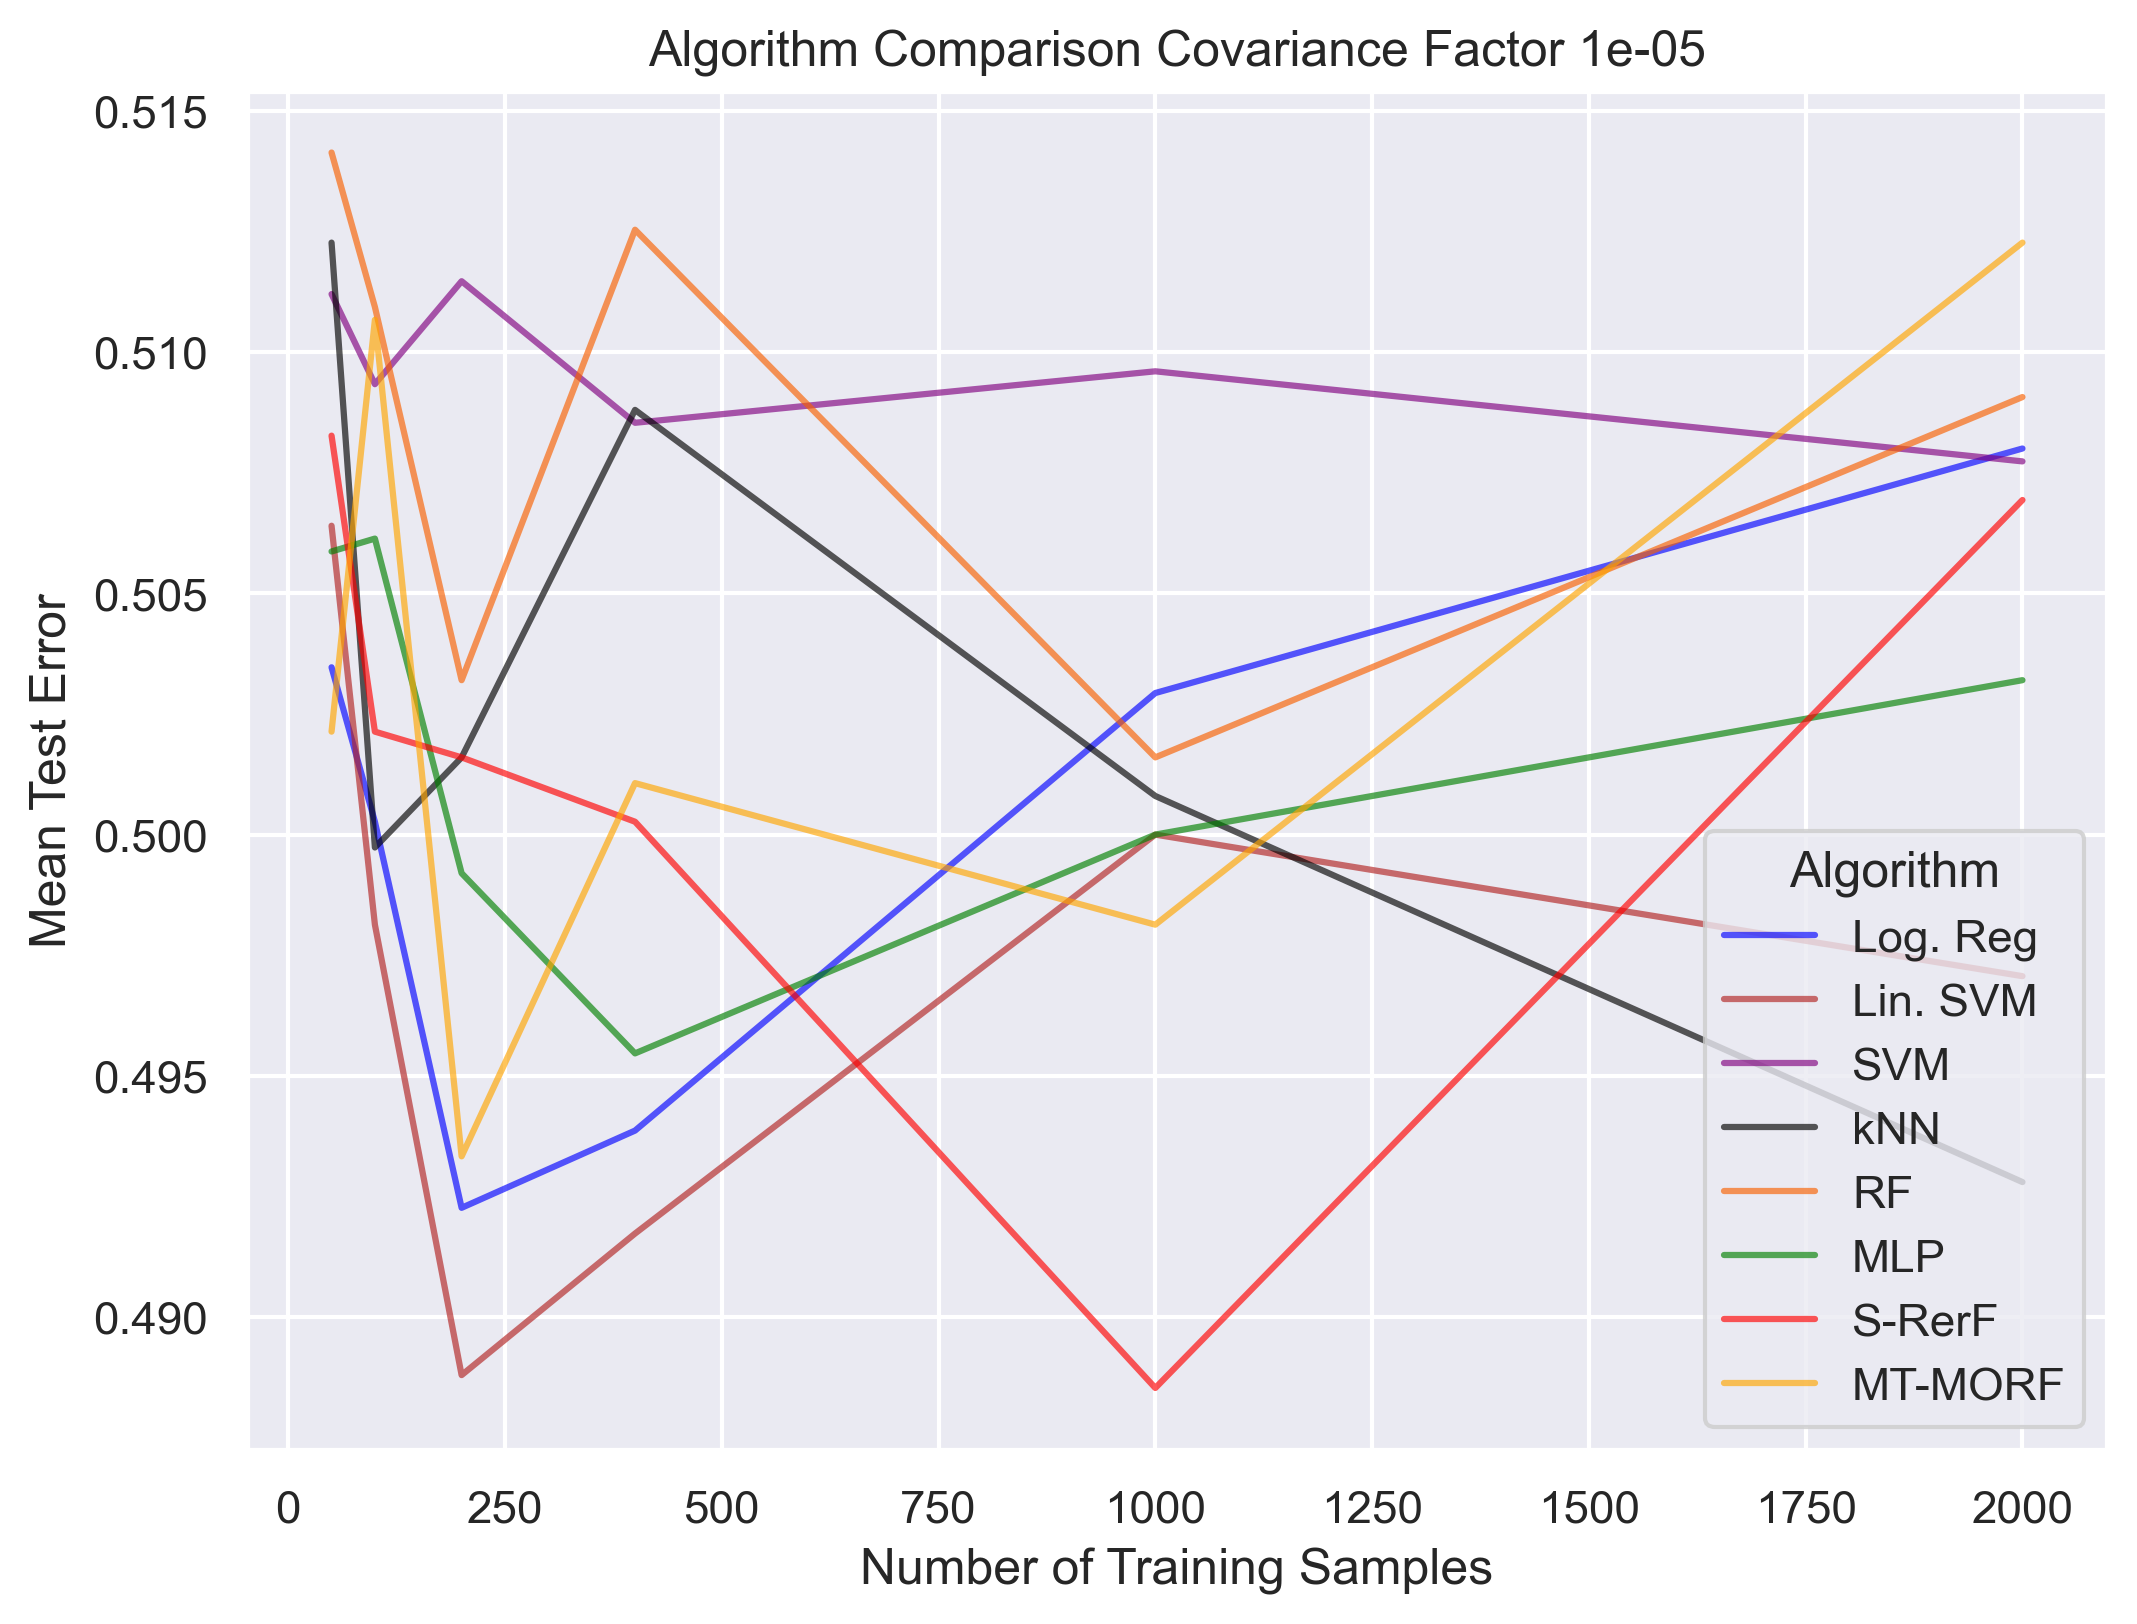

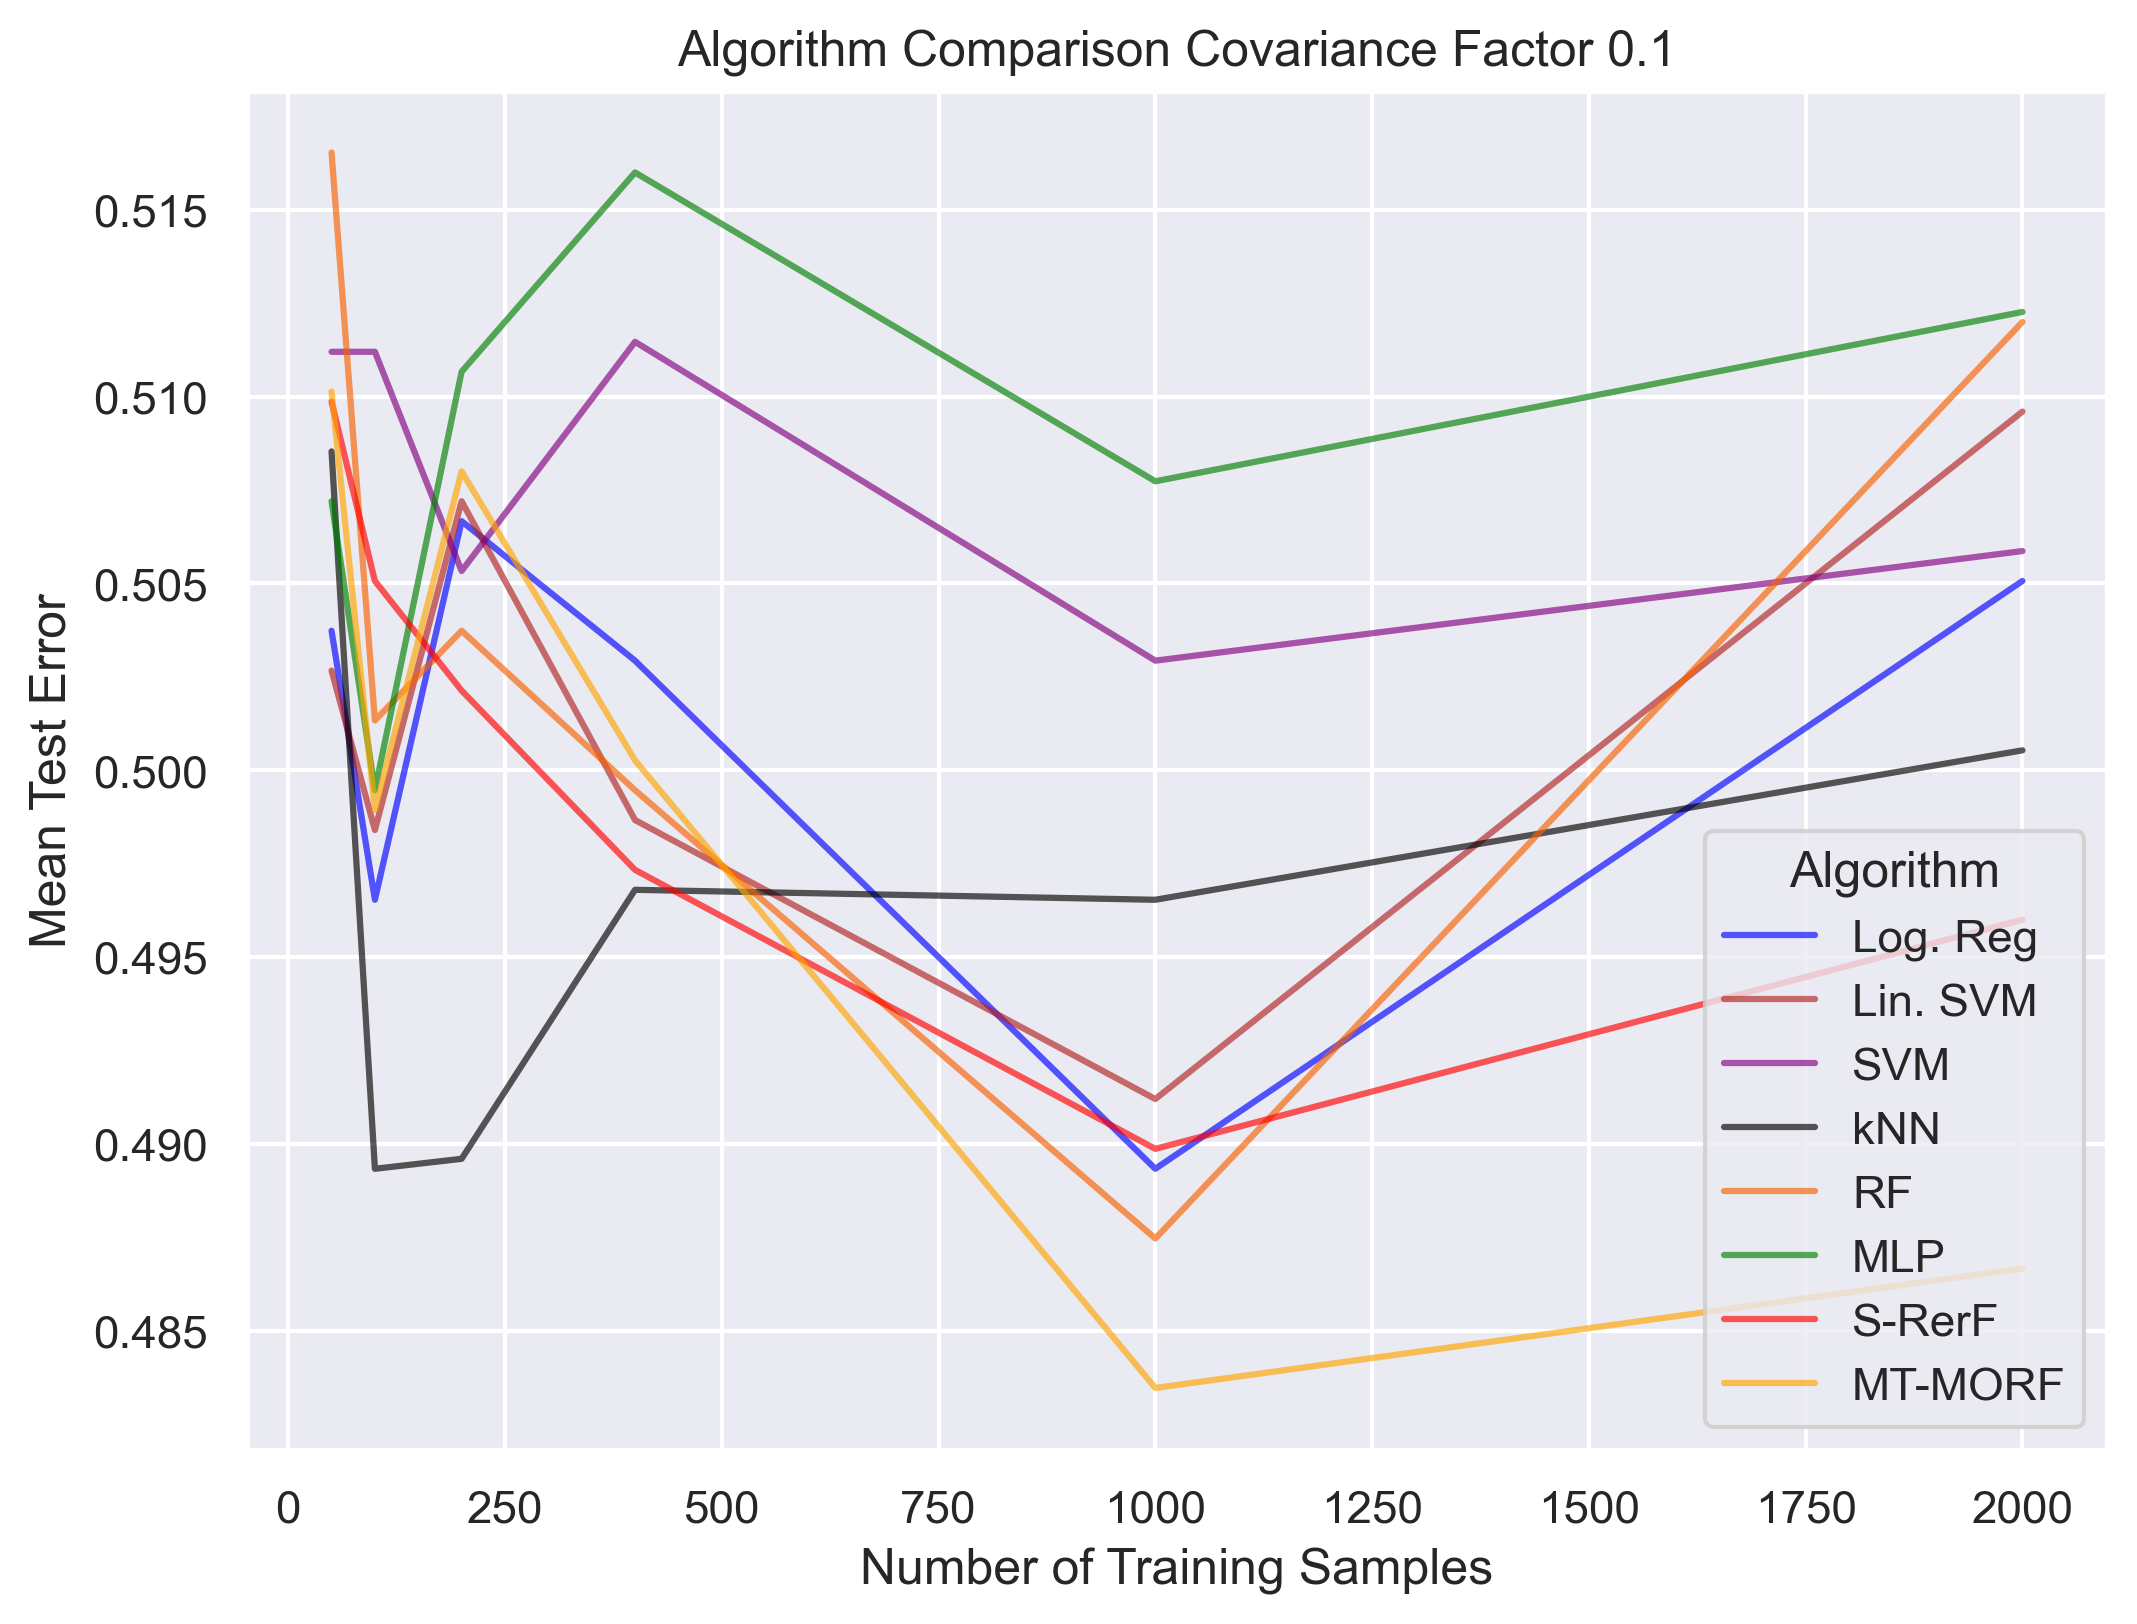

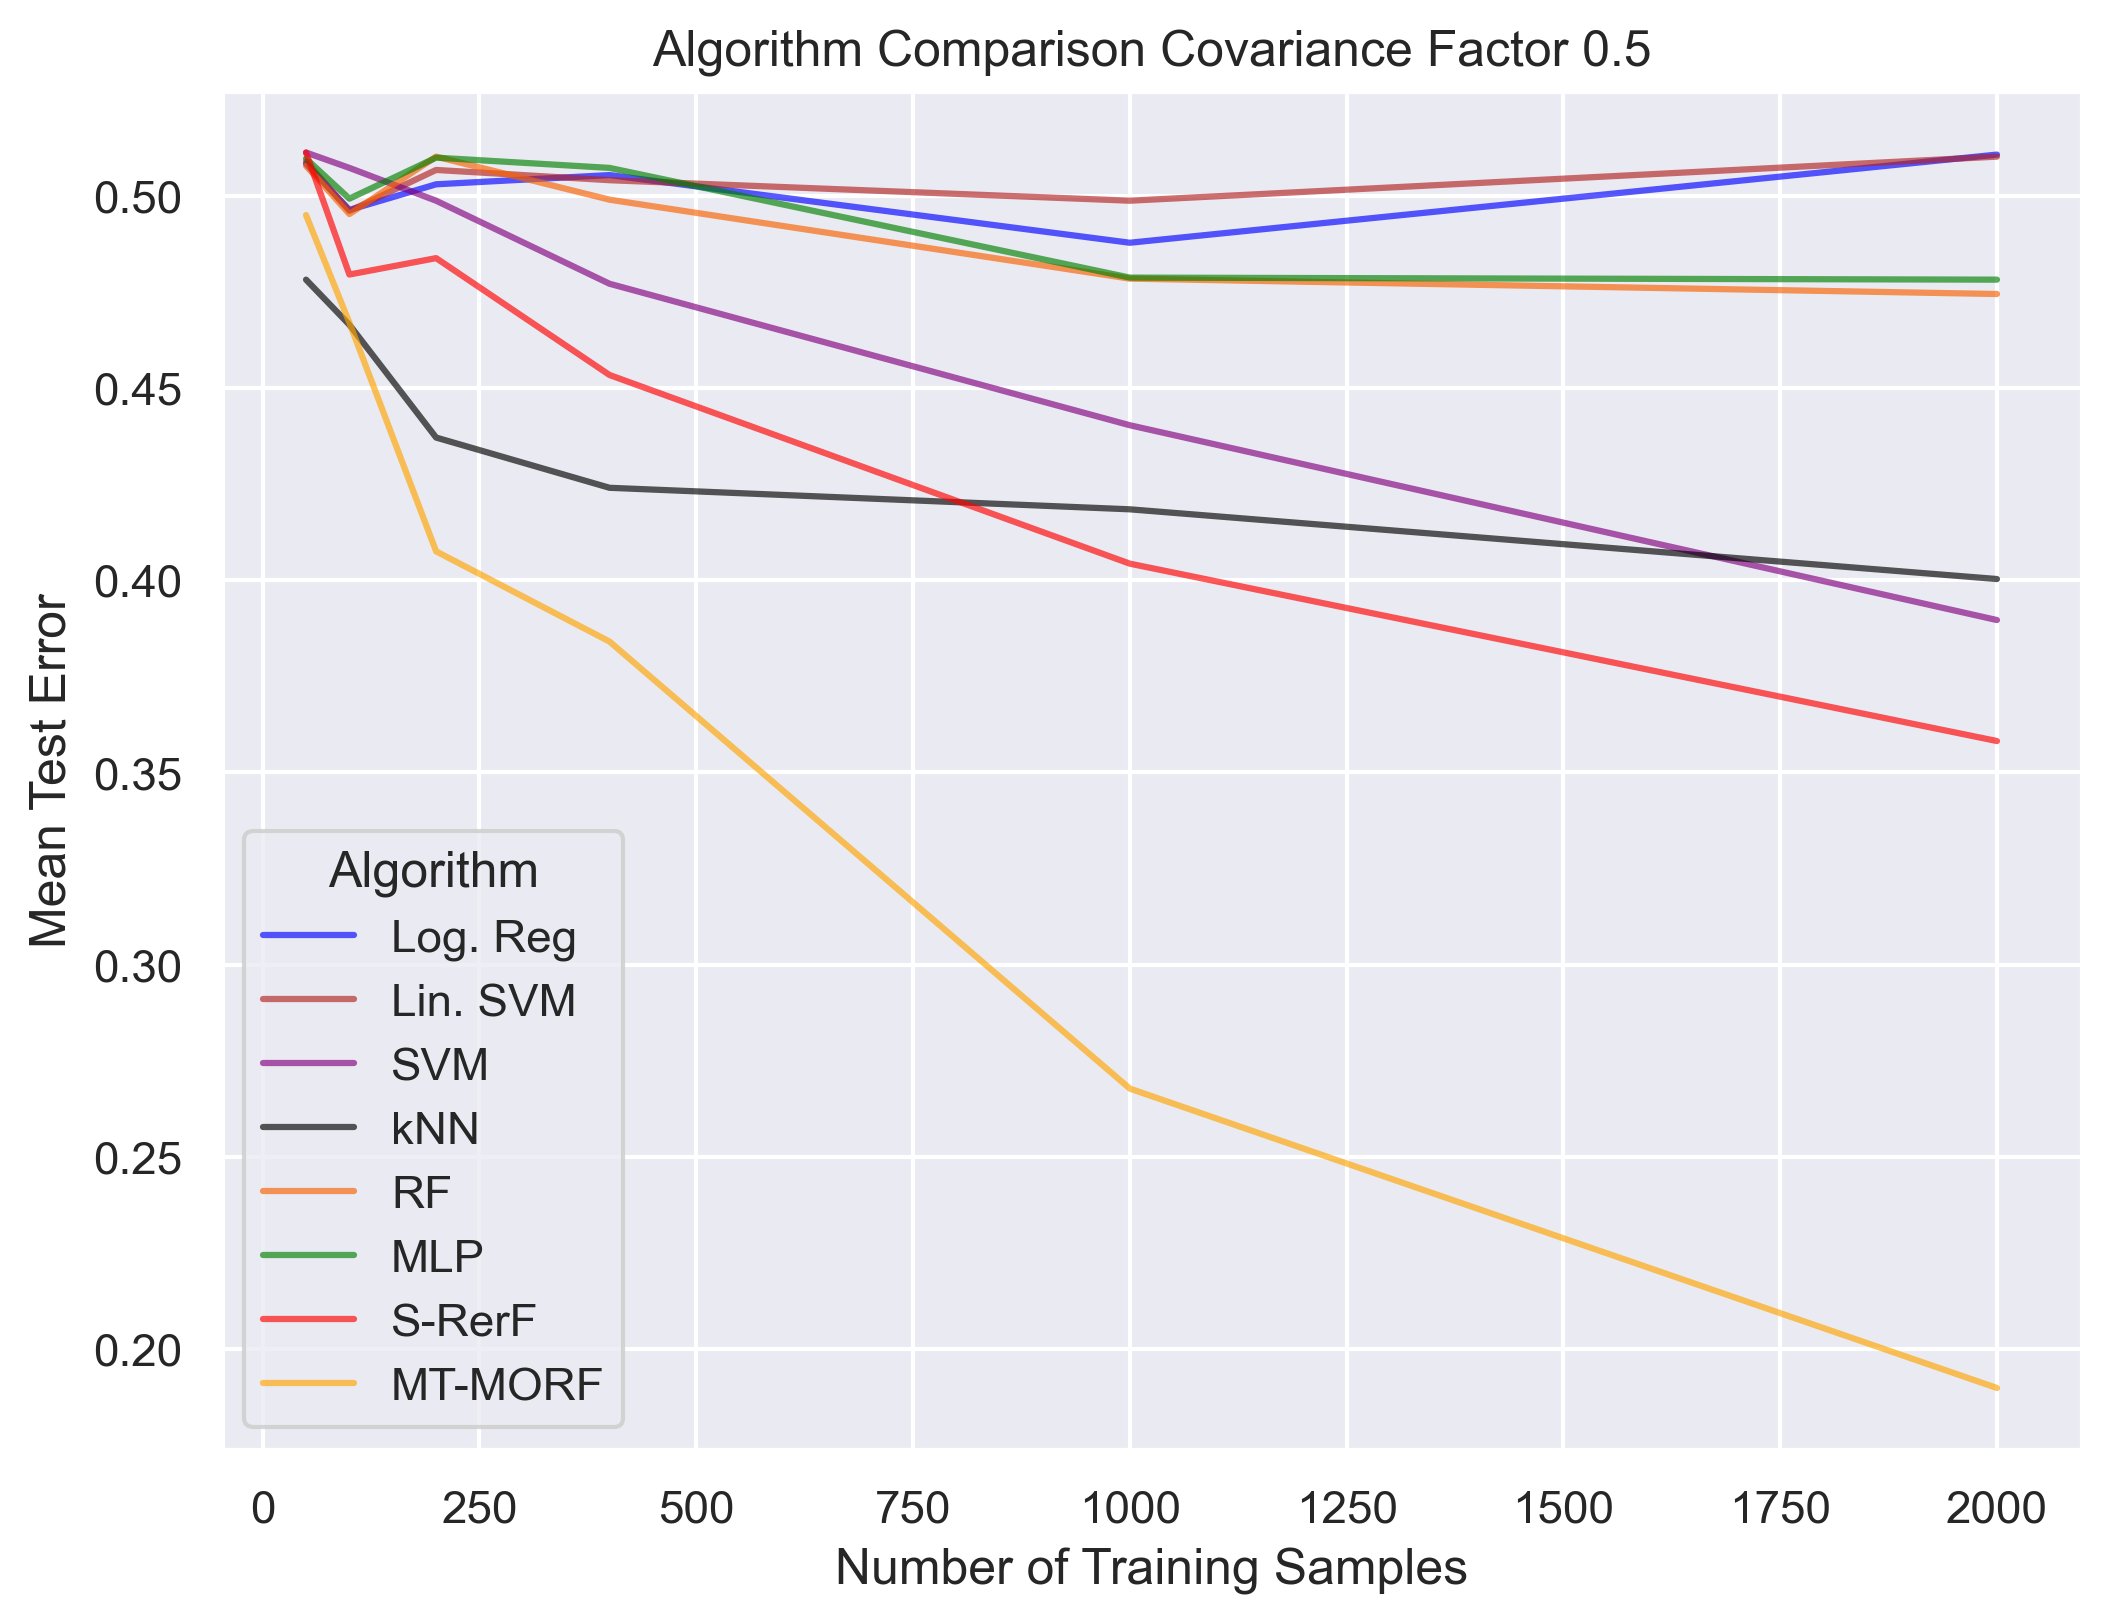

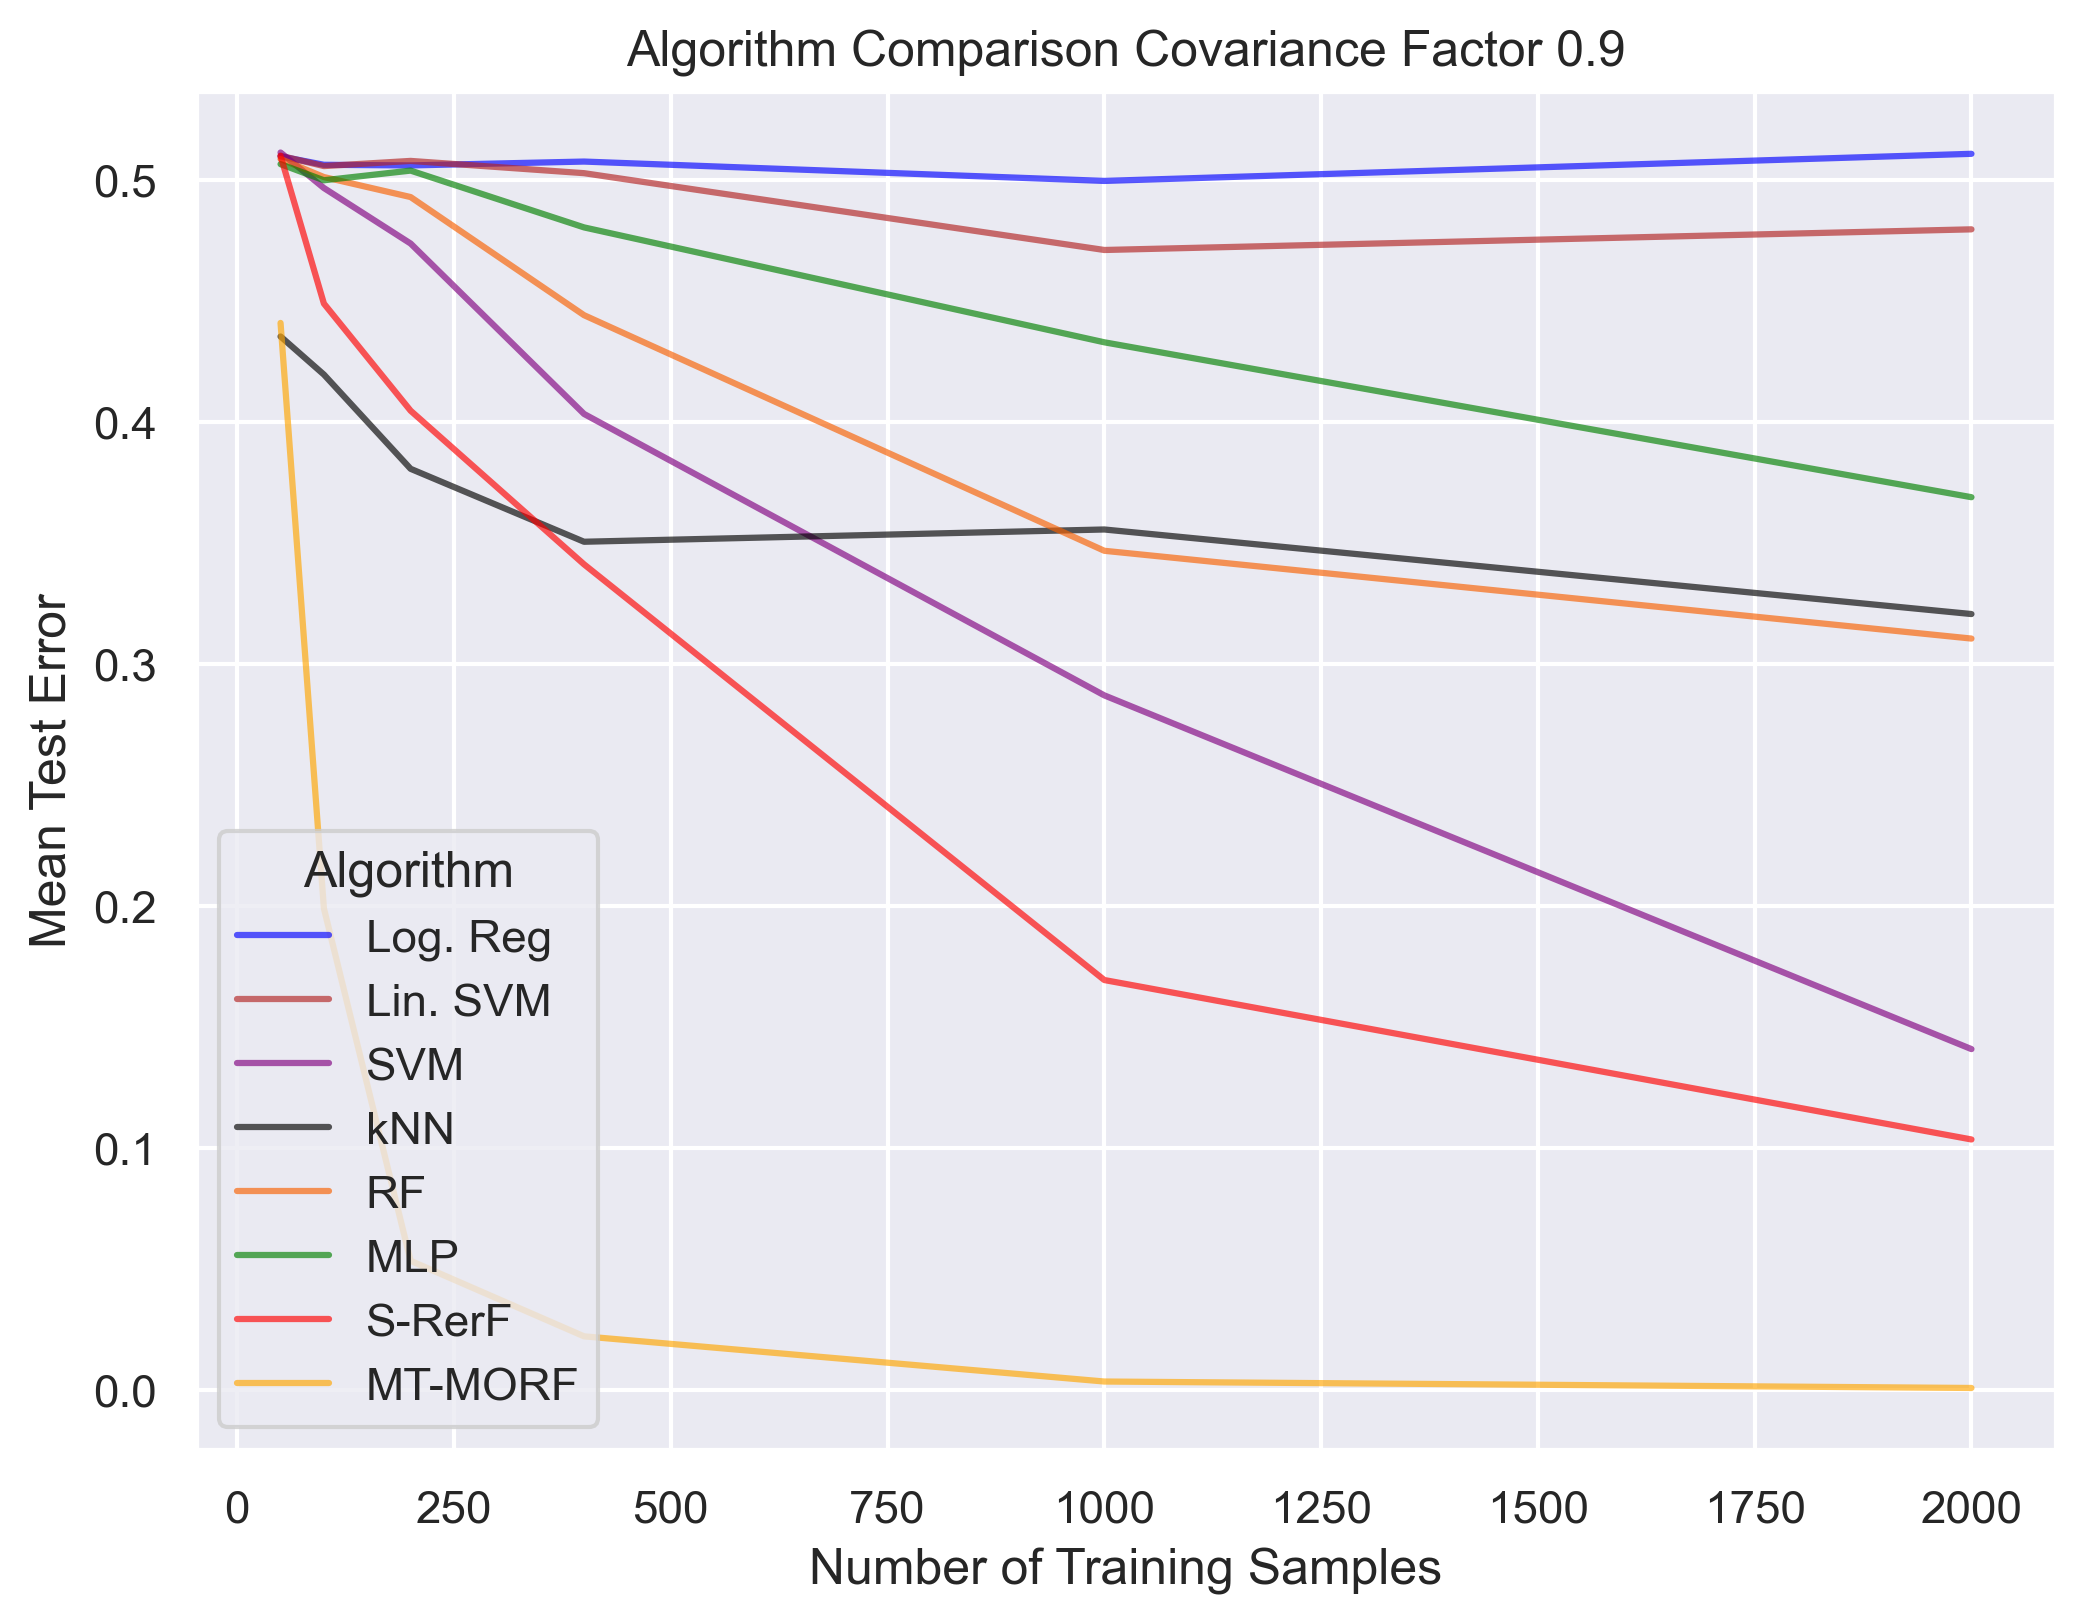

In [17]:
for cov_factor in [1e-5, 0.1, 0.5, 0.9]:
    X_train, y_train, X_test, y_test = simulate_data(cov_factor)
    
    # Train each classifier on each dataset size, then test
    # Prep output file:
    fname = f'./mt-morf_impulse_experiment_covfactor{cov_factor}.csv'

    dat = pd.read_csv(fname)

    d1 = pd.DataFrame(columns = ['classifier', 'n', 'Lhat', 'color'])

    k = 0
    for ni in np.unique(dat['n']):
        for cl in np.unique(dat['classifier']):

            tmp = dat[np.logical_and(dat['classifier'] == cl,dat['n'] == ni)][['n', 'Lhat']]

            list(tmp.mean())
            d1.loc[k] = [cl] + list(tmp.mean()) + [names[cl]]
            k += 1


    sns.set(style="darkgrid", rc={'figure.figsize':[12,8], 'figure.dpi': 300})
    fig, ax = plt.subplots(figsize = (8,6))

    for key in names.keys():
        grp = d1[d1['classifier'] == key]
        ax = grp.plot(ax=ax, kind='line', x='n', y='Lhat', label=key, \
                c = names[key], alpha =0.65)
        #ax.set_yscale('log')

    plt.legend(loc='best',title='Algorithm')
    plt.title(f'Algorithm Comparison Covariance Factor {cov_factor}')
    plt.ylabel('Mean Test Error')
    plt.xlabel('Number of Training Samples')
    #plt.savefig('./s-rerf_impulse_experiment.pdf',dpi=300,format='pdf')
    plt.show()